In [ ]:
# Check no. of TPUs
import tensorflow as tf
print(f"Num GPUs: {len(tf.config.list_physical_devices('GPU'))}")

Num GPUs: 1


## Loading the ASCAD dataset

In [ ]:
import h5py
import numpy as np

ascad_path = "/content/drive/MyDrive/ASCAD_databases/ASCAD.h5"
f = h5py.File(ascad_path, "r")

In [ ]:
# trace_subset = -1

profiling_traces = np.array(f['Profiling_traces/traces'])#[:trace_subset]
profiling_labels = np.array(f['Profiling_traces/labels'])#[:trace_subset]

profiling_metadata = f['Profiling_traces/metadata']#[:trace_subset]

atck_traces = np.array(f['Attack_traces/traces'])#[:trace_subset]
atck_labels = np.array(f['Attack_traces/labels'])#[:trace_subset]

atck_metadata = f['Attack_traces/metadata']#[:trace_subset]

In [ ]:
import tensorflow as tf

# from tf.keras.utils import to_categorical

profiling_labels_cat = tf.keras.utils.to_categorical(profiling_labels, num_classes=256)

atck_labels_cat = tf.keras.utils.to_categorical(atck_labels, num_classes=256)

In [ ]:
metadata_map = {
    "plaintext" : 0,
    "key" : 2,
    "ciphertext" : 1,
    "masks" : 3,
    "desync" : 4
}

profiling_plaintexts = np.array([meta[metadata_map["plaintext"]] for meta in profiling_metadata])
profiling_keys = np.array([meta[metadata_map["key"]] for meta in profiling_metadata])

In [ ]:
p_2 = profiling_metadata['plaintext'][:,2]
k_2 = profiling_metadata['key'][:,2]

## AES utils

In [ ]:
SBOX =  np.array(
        [0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67,
        0x2b, 0xfe, 0xd7, 0xab, 0x76, 0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59,
        0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0, 0xb7,
        0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1,
        0x71, 0xd8, 0x31, 0x15, 0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05,
        0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75, 0x09, 0x83,
        0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29,
        0xe3, 0x2f, 0x84, 0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b,
        0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf, 0xd0, 0xef, 0xaa,
        0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c,
        0x9f, 0xa8, 0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc,
        0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2, 0xcd, 0x0c, 0x13, 0xec,
        0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19,
        0x73, 0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee,
        0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb, 0xe0, 0x32, 0x3a, 0x0a, 0x49,
        0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
        0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4,
        0xea, 0x65, 0x7a, 0xae, 0x08, 0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6,
        0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a, 0x70,
        0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9,
        0x86, 0xc1, 0x1d, 0x9e, 0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e,
        0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf, 0x8c, 0xa1,
        0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0,
        0x54, 0xbb, 0x16])


def apply_sbox(byte):
  # DBG log - print(f"Applying SBOX to {byte}")
  return SBOX[byte]

def hamming_weight(byte):
  return bin(byte).count('1')

In [ ]:
print(f"PTX: {p_2}")
print(f"KEY: {k_2}")

TRACE_NO = 0
print(f"SBX(p[3] ^ k[3]) for trace {TRACE_NO}: {SBOX[np.array(p_2)[TRACE_NO] ^ np.array(k_2)[TRACE_NO]]}")

NameError: name 'p_2' is not defined

## SCA utils

In [ ]:
# SCA evaluation utilities
# TODO: optimize
def calculate_ranks_full(predictions, pts, keys, target_byte=2, rank_step=100):
    num_traces = predictions.shape[0]
    ranks = []
    num_traces_list = list(range(rank_step, num_traces + 1, rank_step))

    for current_num_traces in num_traces_list:
        # Accumulate key probabilities over the current number of traces
        all_key_probabilities = np.zeros(256)  # Initialize once for each set of traces

        for trace_idx in range(current_num_traces):
            plaintext = pts[trace_idx][target_byte]
            correct_key = keys[trace_idx][target_byte]

            key_probabilities = np.zeros(256)
            for key_candidate in range(256):
                sbox_out = SBOX[plaintext ^ key_candidate]
                key_probabilities[key_candidate] += np.log(predictions[trace_idx][sbox_out] + 1e-8)

            all_key_probabilities += key_probabilities  # Accumulate log probabilities

        # Rank the key candidates based on accumulated probabilities
        ranked_keys = np.argsort(all_key_probabilities)[::-1]
        correct_key_rank = np.where(ranked_keys == correct_key)[0][0]
        print(f"Correct key rank: {correct_key_rank}")
        print(f"Correct key: {correct_key}")
        print(f"current_num_traces: {current_num_traces}")
        ranks.append(correct_key_rank)

    return num_traces_list, ranks

In [ ]:
atck_pts = atck_metadata['plaintext']
atck_keys = atck_metadata['key']

## Transformer initial implementation

Plain transformer without using custom positional encodings nor custom attention.

In [ ]:
print(tf.__version__)

2.18.0


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Conv1D, BatchNormalization, Dropout
from tensorflow.keras.models import Model

def positional_encoding(max_len, d_model):
  pos = np.arange(max_len)[:, np.newaxis]
  i = np.arange(d_model)[np.newaxis, :]

  angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
  angle_rads = pos * angle_rates
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  return tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)

class TransformerBlock(tf.keras.layers.Layer):
  def __init__(self, num_heads, d_model, ff_dim, dropout=0.1) -> None:
    """!
    @param[in] d_model Embedding size (result of positional encoding)
    @param[in] num_heads Number of heads per multihead attention layer
    """
    super().__init__()
    self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
    self.ffn = tf.keras.Sequential([
        Dense(ff_dim * 4, activation='relu'),
        Dropout(dropout),
        Dense(d_model, activation='relu'),
        Dropout(dropout)
    ])

    self.dropout = Dropout(dropout)
    self.batchnorm1 = BatchNormalization()
    self.batchnorm2 = BatchNormalization()
    self.last_attn_scores = None

    # This kind of layer norm has been showed by [TransNet] to misbehave
    # self.norm1 = LayerNormalization()
    # self.norm2 = LayerNormalization()

  def call(self, x, training=False, return_attention=False):
    orig = x  # save for attention residual
    if return_attention:
        attn_output, attn_scores = self.att(x, x, return_attention_scores=True)
        self.last_attn_scores = attn_scores
    else:
        attn_output = self.att(x, x)
    x = self.dropout(attn_output, training=training)
    x = x + orig  # residual after attention

    orig = x  # save for FFN residual
    ffn_output = self.ffn(x)
    x = self.dropout(ffn_output, training=training)
    x = x + orig  # residual after FFN

    return x


def build_model(d_model):
  input_trace = Input(shape=(700, 1))
  x = Conv1D(64, kernel_size=11, padding='same', activation='relu')(input_trace)
  x = tf.keras.layers.AveragePooling1D(pool_size=2)(x)
  pos_enc = positional_encoding(350, d_model)
  x += pos_enc
  transformer = TransformerBlock(4, d_model, ff_dim=128)
  x = transformer(x, return_attention=True)
  x = tf.keras.layers.GlobalAveragePooling1D()(x)
  output = Dense(256, activation='softmax')(x)
  model = Model(inputs=input_trace, outputs=output)
  return model, transformer



### ==== START =====
# trace_in = Input(shape=(700,1))

# #Conv 1D
# x = Conv1D(64, kernel_size=11, padding='same', activation='relu')(trace_in)
# x = tf.keras.layers.ReLU()(x)
# x = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2)(x)

# pos_enc = positional_encoding(350, 64)
# x += pos_enc

# NO_TF_LAYERS = 2
# NO_HEADS = 4
# d_model = 64
# hsz = d_model // NO_HEADS

# # for _ in range(NO_TF_LAYERS):
# x = TransformerBlock(num_heads=NO_HEADS, head_size=hsz, ff_dim=256)(x)
# x = TransformerBlock(num_heads=NO_HEADS, head_size=hsz, ff_dim=256)(x)

# x = tf.keras.layers.GlobalAveragePooling1D()(x)
# output = Dense(256, activation='softmax')(x)
### ==== END =====

class WarmupScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, base_lr, warmup_steps=4000):
    super().__init__()
    self.base_lr = base_lr
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, tf.float32)
    warmup = step / (self.warmup_steps ** 1.5)
    decay  = 1.0 / tf.math.sqrt(step)
    return self.base_lr * tf.math.minimum(warmup, decay)

lr_sched = WarmupScheduler(base_lr=0.001, warmup_steps=500)
optim = tf.keras.optimizers.Adam(learning_rate=lr_sched)

# model = Model(trace_in, output)
# model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
# model.summary()

# Hyperparams
d_model = 64

attn_model, tfmr = build_model(d_model)
attn_model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
attn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'transformer_block', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 700, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 700, 64)        │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d               │ (None, 350, 64)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add (Add)                       │ (None, 350, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 350, 64)        │       132,480 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        16,640 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,888 (585.50 KB)

 Trainable params: 149,888 (585.50 KB)

 Non-trainable params: 0 (0.00 B)

## Sanity check on a single (replicated) trace

In [ ]:
trace = profiling_traces[42]
label = np.array(SBOX)[plaintexts ^ keys][42, 2]

NameError: name 'SBOX' is not defined

In [ ]:
from tensorflow.keras.utils import to_categorical
label_oh = to_categorical(label, num_classes=256)

In [ ]:
label_oh.shape

In [ ]:
X_train = np.tile(trace[None, :, None], (128, 1, 1))
y_train = np.tile(label_oh[None, :], (128, 1))

In [ ]:
y_train.shape

In [ ]:
model.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.1)

It seems that the model is successful at classifying the single trace correctly.

---

## Training plain transformer

In [ ]:
# Prep ASCAD data for training
from tensorflow.keras.utils import to_categorical
TARGET_BYTE = 2

# NOTE: labels already present in the dataset - replace this
labels = plaintexts ^ keys
sbox_out = SBOX[labels]
sbox_out = sbox_out[:, TARGET_BYTE]
sbox_out = to_categorical(sbox_out, num_classes=256)

# Reshape the profiling traces
profiling_traces_exp = profiling_traces[..., np.newaxis]
profiling_traces_exp.shape

(49999, 700, 1)

In [ ]:
history = attn_model.fit(x=profiling_traces_exp, y=sbox_out, batch_size=128, epochs=50, validation_split=0.1)

Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 75s 405ms/step - accuracy: 0.0033 - loss: 7.6217 - val_accuracy: 0.0013 - val_loss: 7.1503
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0034 - loss: 6.8644 - val_accuracy: 0.0013 - val_loss: 6.2626
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0027 - loss: 6.0683 - val_accuracy: 0.0047 - val_loss: 5.7617
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0036 - loss: 5.6912 - val_accuracy: 0.0047 - val_loss: 5.5907
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0035 - loss: 5.5745 - val_accuracy: 0.0047 - val_loss: 5.5556
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0046 - loss: 5.5520 - val_accuracy: 0.0020 - val_loss: 5.5520
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0033 - loss: 5.5488 - val_accuracy: 0.0053 - val_loss: 5.5510
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0055 - loss: 5.5480 - val_ac

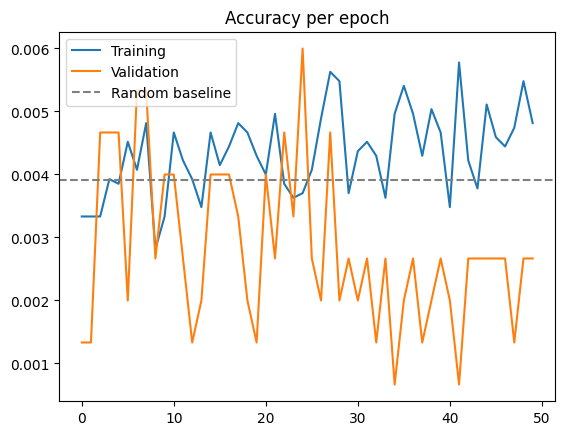

<ipython-input-12-345a50225edc>:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


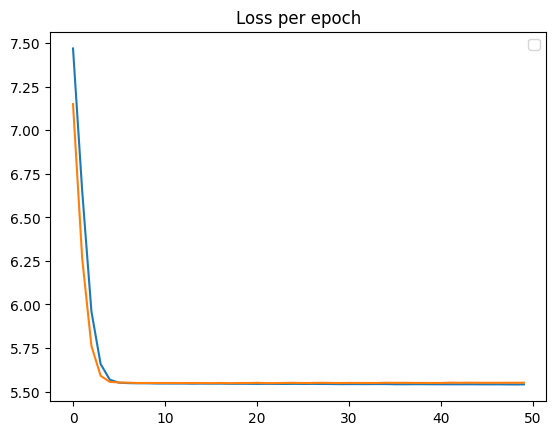

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.axhline(y=1/256, color='gray', linestyle='--', label='Random baseline')
plt.legend()
plt.title("Accuracy per epoch")
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend()
plt.title("Loss per epoch")
plt.show()

In [ ]:
predictions = model.predict(atck_traces)

In [ ]:
attn_predictions = attn_model.predict(atck_traces)

313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step


In [ ]:
_ = attn_model.predict(profiling_traces_exp[1:2])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


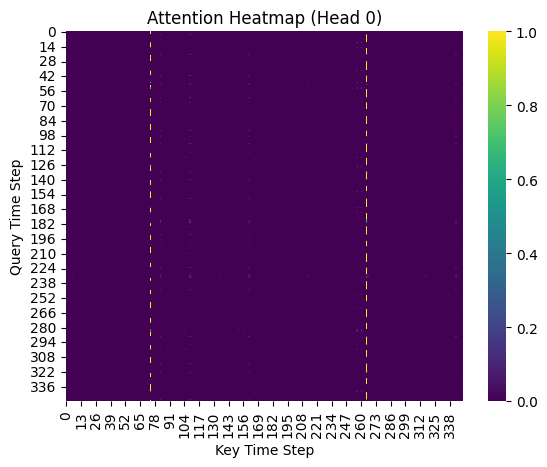

In [ ]:
profiling_traces_exp = profiling_traces_exp.astype(np.float32)

x = profiling_traces_exp[1:2]  # shape (1, 700, 1)
x = tf.keras.layers.AveragePooling1D(pool_size=2)(x)  # becomes (1, 350, 64) after conv
pos_enc = positional_encoding(350, 64)
x += pos_enc  # broadcasted addition

# Now call transformer with return_attention=True
_ = tfmr(x, return_attention=True)
attn_scores = tfmr.last_attn_scores.numpy()

# Visualize
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(attn_scores[0, 0], cmap='viridis')
plt.title("Attention Heatmap (Head 0)")
plt.xlabel("Key Time Step")
plt.ylabel("Query Time Step")
plt.show()

In [ ]:
print(type(tfmr.last_attn_scores))

<class 'tensorflow.python.framework.ops.SymbolicTensor'>


In [ ]:
attn_scores = tfmr.last_attn_scores.numpy()

import seaborn as sns
sns.heatmap(attn_scores[0, 0], cmap='viridis')
plt.title("Attention Heatmap (Head 0)")
plt.xlabel("Key Time Step")
plt.ylabel("Query Time Step")
plt.show()

AttributeError: 'SymbolicTensor' object has no attribute 'numpy'

In [ ]:
np.max(predictions[:10][0])

np.float32(0.0097463215)

## Evaluating 'transformer' model

In [ ]:
num_traces_list, ranks = calculate_ranks_full(attn_predictions, atck_pts, atck_keys, target_byte=2, rank_step=100)

Correct key rank: 239
Correct key: 224
current_num_traces: 100
Correct key rank: 98
Correct key: 224
current_num_traces: 200
Correct key rank: 92
Correct key: 224
current_num_traces: 300
Correct key rank: 90
Correct key: 224
current_num_traces: 400
Correct key rank: 131
Correct key: 224
current_num_traces: 500
Correct key rank: 159
Correct key: 224
current_num_traces: 600
Correct key rank: 155
Correct key: 224
current_num_traces: 700
Correct key rank: 124
Correct key: 224
current_num_traces: 800
Correct key rank: 99
Correct key: 224
current_num_traces: 900
Correct key rank: 72
Correct key: 224
current_num_traces: 1000
Correct key rank: 117
Correct key: 224
current_num_traces: 1100
Correct key rank: 109
Correct key: 224
current_num_traces: 1200
Correct key rank: 126
Correct key: 224
current_num_traces: 1300
Correct key rank: 135
Correct key: 224
current_num_traces: 1400
Correct key rank: 149
Correct key: 224
current_num_traces: 1500
Correct key rank: 160
Correct key: 224
current_num_tra

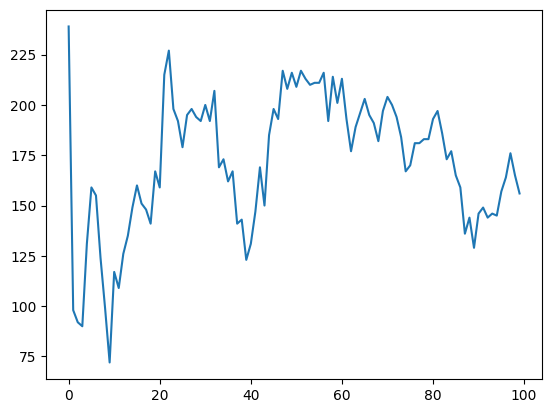

In [ ]:
import matplotlib.pyplot as plt

plt.plot(ranks)

## Hyperparam tuner attempt

In [ ]:
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.4 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

In [ ]:
def model_builder(hp):
  input_trace = Input(shape=(700, 1))

  hp_feature_maps = hp.Int('conv_feature_maps', min_value=32, max_value=128, step=32)
  hp_kernel_sizes = hp.Int('conv_kernel_sizes', min_value = 5, max_value = 23, step = 6)
  x = Conv1D(hp_feature_maps, kernel_size=hp_kernel_sizes, padding='same', activation='relu')(input_trace)
  x = tf.keras.layers.AveragePooling1D(pool_size=1)(x)

  hp_d_model = hp_feature_maps #hp.Int('d_models', min_value=32, max_value=128, step=32)
  pos_enc = positional_encoding(700, hp_d_model)
  x += pos_enc

  hp_attn_heads = hp.Int('attn_heads', min_value=2, max_value=8, step=2)
  hp_ff_dim = hp.Int('transformer_ff_dim', min_value=64, max_value=256, step=64)
  transformer = TransformerBlock(hp_attn_heads, hp_d_model, ff_dim=hp_ff_dim)
  x = transformer(x, return_attention=True)
  x = tf.keras.layers.GlobalAveragePooling1D()(x)
  output = Dense(256, activation='softmax')(x)
  model = Model(inputs=input_trace, outputs=output)

  hp_learning_rate_base = hp.Choice('lr_base', values=[0.001, 0.005, 0.01, 0.05, 0.0001, 0.0005])
  hp_warmup_steps = hp.Choice('warmup_steps', values=[100, 500, 1000, 2000])
  lr_sched = WarmupScheduler(base_lr=hp_learning_rate_base, warmup_steps=hp_warmup_steps)
  optim = tf.keras.optimizers.Adam(learning_rate=lr_sched)

  model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='/content/drive/MyDrive',
                     project_name='transformer_kt')

Reloading Tuner from /content/drive/MyDrive/transformer_kt/tuner0.json


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

tuner.search(profiling_traces_exp, sbox_out, epochs=50, validation_split=0.1, callbacks=[stop_early])

Trial 30 Complete [00h 02m 39s]
val_accuracy: 0.01066666655242443

Best val_accuracy So Far: 0.012666666880249977
Total elapsed time: 08h 59m 21s


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'transformer_block_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [ ]:
print("--- Model hps ---")
print('conv_feature_maps')
print(best_hps.get('conv_feature_maps'))
print('conv_kernel_sizes')
print(best_hps.get('conv_kernel_sizes'))
print('attn_heads')
print(best_hps.get('attn_heads'))
print('transformer_ff_dim')
print(best_hps.get('transformer_ff_dim'))

print("--- Training hps ---")
print('lr_base')
print(best_hps.get('lr_base'))
print('warmup_steps')
print(best_hps.get('warmup_steps'))

--- Model hps ---
conv_feature_maps
128
conv_kernel_sizes
11
attn_heads
8
transformer_ff_dim
256
--- Training hps ---
lr_base
0.001
warmup_steps
100


In [ ]:
history_best = best_model.fit(profiling_traces_exp, sbox_out, batch_size=128, epochs=100, validation_split=0.1)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 74s 440ms/step - accuracy: 0.0067 - loss: 6.7862 - val_accuracy: 0.0027 - val_loss: 5.4730
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.0093 - loss: 5.4539 - val_accuracy: 0.0073 - val_loss: 5.4088
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.0084 - loss: 5.3976 - val_accuracy: 0.0087 - val_loss: 5.3818
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.0091 - loss: 5.3676 - val_accuracy: 0.0080 - val_loss: 5.3736
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.0076 - loss: 5.3560 - val_accuracy: 0.0080 - val_loss: 5.3670
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.0057 - loss: 5.3583 - val_accuracy: 0.0073 - val_loss: 5.3661
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.0068 - loss: 5.3465 - val_accuracy: 0.0080 - val_loss: 5.3598
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.0085 - loss: 5.3475 

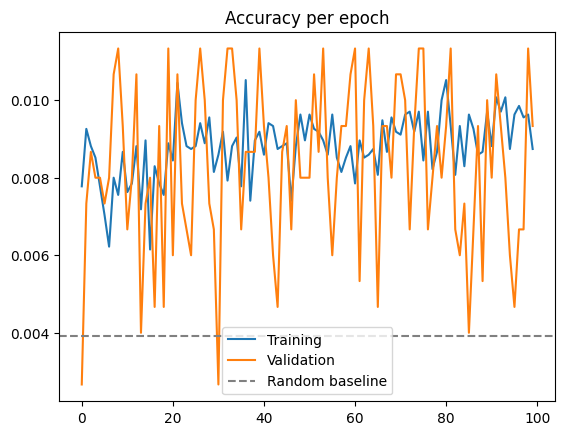

<ipython-input-18-dec3406e20e2>:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


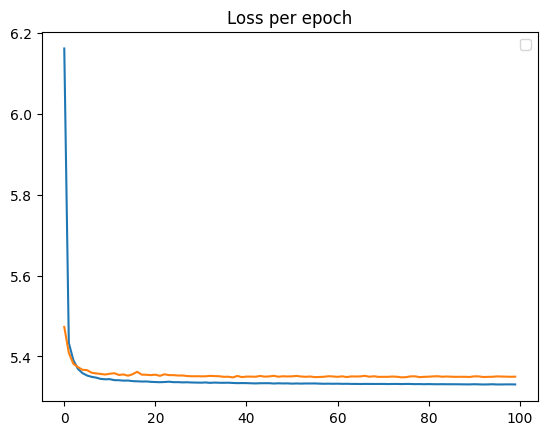

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history_best.history['accuracy'], label='Training')
plt.plot(history_best.history['val_accuracy'], label='Validation')
plt.axhline(y=1/256, color='gray', linestyle='--', label='Random baseline')
plt.legend()
plt.title("Accuracy per epoch")
plt.show()

plt.plot(history_best.history['loss'])
plt.plot(history_best.history['val_loss'])
plt.legend()
plt.title("Loss per epoch")
plt.show()

In [ ]:
from google.colab import drive
import json

# drive.mount('/content/drive')
best_model.save_weights('/content/drive/MyDrive/best_transformer_weights_kt_search_trained_100_epochs_15k_traces_val_loss.weights.h5')


with open('/content/drive/MyDrive/best_hps.json', 'w') as f:
    json.dump(best_hps.values, f)

In [ ]:
best_model.save('best_transformer_kt_search.h5')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

best_model.save('/content/drive/MyDrive/best_transformer_kt_search.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


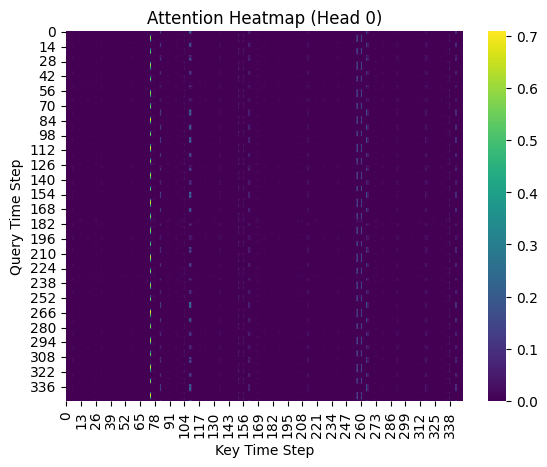

In [ ]:
#best_model_preds = best_model.predict()
_ = best_model.predict(profiling_traces[1:2])

profiling_traces_exp = profiling_traces_exp.astype(np.float32)

x = profiling_traces_exp[1:2]  # shape (1, 700, 1)
x = tf.keras.layers.AveragePooling1D(pool_size=2)(x)  # becomes (1, 350, 64) after conv
pos_enc = positional_encoding(350, 64)
x += pos_enc  # broadcasted addition

# Now call transformer with return_attention=True
_ = tfmr(x, return_attention=True)
attn_scores = tfmr.last_attn_scores.numpy()

# Visualize
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(attn_scores[0, 0], cmap='viridis')
plt.title("Attention Heatmap (Head 0)")
plt.xlabel("Key Time Step")
plt.ylabel("Query Time Step")
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Correct key rank: 253
Correct key: 224
current_num_traces: 100
Correct key rank: 174
Correct key: 224
current_num_traces: 200
Correct key rank: 151
Correct key: 224
current_num_traces: 300
Correct key rank: 76
Correct key: 224
current_num_traces: 400
Correct key rank: 92
Correct key: 224
current_num_traces: 500
Correct key rank: 143
Correct key: 224
current_num_traces: 600
Correct key rank: 73
Correct key: 224
current_num_traces: 700
Correct key rank: 92
Correct key: 224
current_num_traces: 800
Correct key rank: 133
Correct key: 224
current_num_traces: 900
Correct key rank: 110
Correct key: 224
current_num_traces: 1000
Correct key rank: 143
Correct key: 224
current_num_traces: 1100
Correct key rank: 163
Correct key: 224
current_num_traces: 1200
Correct key rank: 190
Correct key: 224
current_num_traces: 1300
Correct key rank: 211
Correct key: 224
current_num_traces: 1400
Correct key rank: 210
Correct key: 224
current_num_traces: 1500
Correct key 

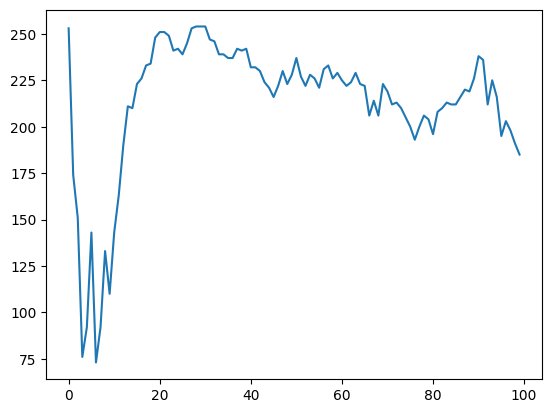

In [ ]:
best_predictions = best_model.predict(atck_traces)
best_num_traces_list, best_ranks = calculate_ranks_full(best_predictions, atck_pts, atck_keys, target_byte=2, rank_step=100)

plt.plot(best_ranks)

## MLP sanity check

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.utils import to_categorical

def build_mlp_model(input_dim, output_dim=256):
  model = Sequential()

  model.add(Dense(200, input_shape=(input_dim,), activation='relu' ))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(200, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(200, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(200, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(200, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(200, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(output_dim, activation='softmax'))
  return model

In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop

# y_simulated = to_categorical(labels_byte_2, num_classes=256)

model_simulated = build_mlp_model(profiling_traces.shape[1])
model_simulated.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

model_simulated.fit(profiling_traces, sbox_out, batch_size=100, epochs=50, validation_split=0.2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.0037 - loss: 6.0769 - val_accuracy: 0.0040 - val_loss: 6.3022
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0036 - loss: 6.0497 - val_accuracy: 0.0037 - val_loss: 5.7476
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0041 - loss: 6.0017 - val_accuracy: 0.0057 - val_loss: 5.7310
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0037 - loss: 5.9732 - val_accuracy: 0.0030 - val_loss: 5.7219
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0048 - loss: 5.9456 - val_accuracy: 0.0057 - val_loss: 5.6816
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0060 - loss: 5.9060 - val_accuracy: 0.0050 - val_loss: 5.6903
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0036 - loss: 5.9028 - val_accuracy: 0.0037 - val_loss: 5.6920
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0046 - loss: 5.8700 - val_accuracy: 

In [ ]:
mlp_predictions = model_simulated.predict(atck_traces)

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step


In [ ]:
mlp_num_traces_list, mlp_ranks = calculate_ranks_full(mlp_predictions, atck_pts, atck_keys, target_byte=2, rank_step=100)

Correct key rank: 197
Correct key: 224
current_num_traces: 100
Correct key rank: 52
Correct key: 224
current_num_traces: 200
Correct key rank: 97
Correct key: 224
current_num_traces: 300
Correct key rank: 29
Correct key: 224
current_num_traces: 400
Correct key rank: 25
Correct key: 224
current_num_traces: 500
Correct key rank: 1
Correct key: 224
current_num_traces: 600
Correct key rank: 13
Correct key: 224
current_num_traces: 700
Correct key rank: 19
Correct key: 224
current_num_traces: 800
Correct key rank: 38
Correct key: 224
current_num_traces: 900
Correct key rank: 36
Correct key: 224
current_num_traces: 1000
Correct key rank: 49
Correct key: 224
current_num_traces: 1100
Correct key rank: 20
Correct key: 224
current_num_traces: 1200
Correct key rank: 17
Correct key: 224
current_num_traces: 1300
Correct key rank: 19
Correct key: 224
current_num_traces: 1400
Correct key rank: 17
Correct key: 224
current_num_traces: 1500
Correct key rank: 12
Correct key: 224
current_num_traces: 1600
C

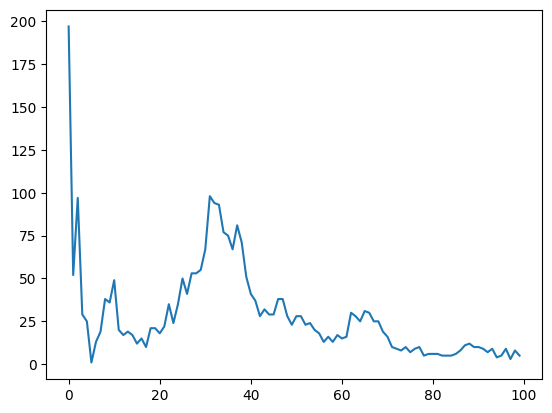

In [ ]:
import matplotlib.pyplot as plt

plt.plot(mlp_ranks)

In [ ]:
model_simulated.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 200)            │       140,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │        51,456 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,187,570 (4.53 MB)

 Trainable params: 395,056 (1.51 MB)

 Non-trainable params: 2,400 (9.38 KB)

 Optimizer params: 790,114 (3.01 MB)

## TransNet initial

Sanity check using TransNet as a starting point for ASCAD attacks

In [ ]:
import tensorflow as tf

In [ ]:
def shape_list(x):
    """Deal with dynamic shape in tensorflow cleanly."""
    static = x.shape.as_list()
    dynamic = tf.shape(x)
    return [dynamic[i] if s is None else s for i, s in enumerate(static)]

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, demb, **kwargs):
        super().__init__(**kwargs)

        self.inv_freq = 1 / (10000 ** (tf.range(0, demb, 2.0) / demb))

    def call(self, pos_seq, bsz=None):
        sinusoid_inp = tf.einsum("i,j->ij", pos_seq, self.inv_freq)
        pos_emb = tf.concat([tf.sin(sinusoid_inp), tf.cos(sinusoid_inp)], -1)

        if bsz is not None:
            return tf.tile(pos_emb[:, None, :], [1, bsz, 1])
        else:
            return pos_emb[:, None, :]

In [ ]:
class PositionwiseFF(tf.keras.layers.Layer):
    def __init__(self, d_model, d_inner, dropout, kernel_initializer,
                 **kwargs):
        super().__init__(**kwargs)

        self.d_model = d_model
        self.d_inner = d_inner
        self.dropout = dropout

        self.layer_1 = tf.keras.layers.Dense(
            d_inner, kernel_initializer=kernel_initializer, activation=tf.nn.relu, name='layer_1'
        )
        self.drop_1 = tf.keras.layers.Dropout(dropout, name='drop_1')
        self.layer_2 = tf.keras.layers.Dense(d_model, kernel_initializer=kernel_initializer, name='layer_2')
        self.drop_2 = tf.keras.layers.Dropout(dropout, name='drop_2')


    def call(self, inp, training=False):
        core_out = inp
        core_out = self.layer_1(core_out)
        core_out = self.drop_1(core_out, training=training)
        core_out = self.layer_2(core_out)
        core_out = self.drop_2(core_out, training=training)

        output = [core_out + inp]
        return output

In [ ]:
class RelativeMultiHeadAttn(tf.keras.layers.Layer):
    def __init__(
        self,
        n_head,
        d_model,
        d_head,
        dropout,
        dropatt,
        kernel_initializer,
        r_r_bias=None,
        r_w_bias=None,
        smooth_pos_emb=True,
        untie_pos_emb=True,
        clamp_len=-1,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.n_head = n_head
        self.d_model = d_model
        self.d_head = d_head
        self.dropout = dropout
        self.kernel_initializer = kernel_initializer
        self.smooth_pos_emb = smooth_pos_emb
        self.untie_pos_emb = untie_pos_emb
        self.clamp_len = clamp_len

        self.qkv_net = tf.keras.layers.Dense(
            3 * n_head * d_head, kernel_initializer=kernel_initializer, use_bias=False, name="qkv"
        )

        if self.smooth_pos_emb:
            self.r_net = tf.keras.layers.Dense(
                self.n_head * self.d_head, kernel_initializer=kernel_initializer, use_bias=False, name="r"
            )
        elif self.untie_pos_emb:
            self.pos_emb = tf.keras.layers.Embedding(
                2*self.clamp_len+1, d_model, name='pos_emb'
            )

        self.drop_r = tf.keras.layers.Dropout(dropout)
        self.drop = tf.keras.layers.Dropout(dropout)
        self.dropatt = tf.keras.layers.Dropout(dropatt)
        self.o_net = tf.keras.layers.Dense(
            d_model, kernel_initializer=kernel_initializer, use_bias=False, name="o"
        )

        self.scale = 1 / (d_head ** 0.5)

        if r_r_bias is not None and r_w_bias is not None:  # Biases are shared
            self.r_r_bias = r_r_bias
            self.r_w_bias = r_w_bias
        else:
            self.r_r_bias = self.add_weight(
                shape=(self.n_head, self.d_head), initializer="zeros", trainable=True, name="r_r_bias"
            )
            self.r_w_bias = self.add_weight(
                shape=(self.n_head, self.d_head), initializer="zeros", trainable=True, name="r_w_bias"
            )

    def _rel_shift(self, x):
        x_size = shape_list(x)

        x = tf.pad(x, [[0, 0], [1, 0], [0, 0], [0, 0]])
        x = tf.reshape(x, [x_size[1] + 1, x_size[0], x_size[2], x_size[3]])
        x = tf.slice(x, [1, 0, 0, 0], [-1, -1, -1, -1])
        x = tf.reshape(x, x_size)

        return x

    def call(self, inputs, training=False):
        w, r = inputs
        qlen, rlen, bsz = shape_list(w)[0], shape_list(r)[0], shape_list(w)[1]

        w_heads = self.qkv_net(w)

        if not self.smooth_pos_emb and self.untie_pos_emb:
            r = self.pos_emb(r)
        r_drop = self.drop_r(r, training=training)

        if self.smooth_pos_emb:
            r_head_k = self.r_net(r_drop)
        else:
            r_head_k = r_drop

        w_head_q, w_head_k, w_head_v = tf.split(w_heads, 3, axis=-1)
        w_head_q = w_head_q[-qlen:]

        klen = shape_list(w_head_k)[0]

        w_head_q = tf.reshape(w_head_q, (qlen, bsz, self.n_head, self.d_head))
        w_head_k = tf.reshape(w_head_k, (klen, bsz, self.n_head, self.d_head))
        w_head_v = tf.reshape(w_head_v, (klen, bsz, self.n_head, self.d_head))

        r_head_k = tf.reshape(r_head_k, (rlen, self.n_head, self.d_head))

        rw_head_q = w_head_q + self.r_w_bias
        rr_head_q = w_head_q + self.r_r_bias

        AC = tf.einsum("ibnd,jbnd->ijbn", rw_head_q, w_head_k)
        BD = tf.einsum("ibnd,jnd->ijbn", rr_head_q, r_head_k)
        BD = self._rel_shift(BD)
        BD = BD[:, :klen, :, :]

        attn_score = AC + BD
        attn_score = attn_score * self.scale

        attn_prob = tf.nn.softmax(attn_score, axis=1)
        attn_prob = self.dropatt(attn_prob, training=training)

        attn_vec = tf.einsum("ijbn,jbnd->ibnd", attn_prob, w_head_v)
        size_t = shape_list(attn_vec)
        attn_vec = tf.reshape(attn_vec, (size_t[0], size_t[1], self.n_head * self.d_head))

        attn_out = self.o_net(attn_vec)
        attn_out = self.drop(attn_out, training=training)

        outputs = [w + attn_out, attn_prob, AC, BD]

        return outputs

In [ ]:
class TransformerLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        n_head,
        d_model,
        d_head,
        d_inner,
        dropout,
        dropatt,
        initializer,
        r_w_bias=None,
        r_r_bias=None,
        smooth_pos_emb=True,
        untie_pos_emb=True,
        clamp_len=-1,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.n_head = n_head
        self.d_model = d_model
        self.d_head = d_head
        self.d_inner = d_inner
        self.dropout = dropout
        self.dropatt = dropatt
        self.initializer = initializer
        self.smooth_pos_emb = smooth_pos_emb
        self.untie_pos_emb = untie_pos_emb
        self.clamp_len = clamp_len

        self.xltran_attn = RelativeMultiHeadAttn(
            n_head=self.n_head,
            d_model=self.d_model,
            d_head=self.d_head,
            dropout=self.dropout,
            dropatt=self.dropatt,
            kernel_initializer=self.initializer,
            r_w_bias=r_w_bias,
            r_r_bias=r_r_bias,
            smooth_pos_emb=self.smooth_pos_emb,
            untie_pos_emb=self.untie_pos_emb,
            clamp_len=self.clamp_len,
            name="xltran_attn",
        )
        self.pos_ff = PositionwiseFF(
            d_model=self.d_model,
            d_inner=self.d_inner,
            dropout=self.dropout,
            kernel_initializer=self.initializer,
            name="pos_ff",
        )

    def call(self, inputs, training=False):
        inp, r = inputs
        attn_outputs = self.xltran_attn([inp, r], training=training)
        ff_output = self.pos_ff(attn_outputs[0], training=training)

        outputs = [ff_output[0]] + attn_outputs[1:]

        return outputs


In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, n_layer, d_model, n_head, d_head, d_inner, dropout, dropatt,
                 n_classes, conv_kernel_size, pool_size, initializer, clamp_len=-1,
                 untie_r=False, smooth_pos_emb=True, untie_pos_emb=True, output_attn=False):

        super(Transformer, self).__init__()

        self.n_layer = n_layer
        self.d_model = d_model
        self.n_head = n_head
        self.d_head = d_head
        self.d_inner = d_inner

        self.dropout = dropout
        self.dropatt = dropatt

        self.n_classes = n_classes

        self.conv_kernel_size = conv_kernel_size
        self.pool_size = pool_size

        self.clamp_len = clamp_len
        self.untie_r = untie_r
        self.smooth_pos_emb = smooth_pos_emb
        self.untie_pos_emb = untie_pos_emb

        self.output_attn = output_attn

        self.initializer = initializer

        self.conv1 = tf.keras.layers.Conv1D(self.d_model, self.conv_kernel_size)
        self.relu1 = tf.keras.layers.ReLU()

        self.pool1 = tf.keras.layers.AveragePooling1D(self.pool_size, self.pool_size)

        if self.smooth_pos_emb:
            self.pos_emb = PositionalEmbedding(d_model)
        else:
            assert(self.clamp_len > 0)
            if not self.untie_pos_emb:
                self.pos_emb = tf.keras.layers.Embedding(
                    2*self.clamp_len+1, d_model, name='pos_emb'
                )
            else:
                self.pos_emb = None

        if not self.untie_r:
            self.r_w_bias = self.add_weight(
                shape=(self.n_head, self.d_head), initializer="zeros", trainable=True, name="r_w_bias"
            )
            self.r_r_bias = self.add_weight(
                shape=(self.n_head, self.d_head), initializer="zeros", trainable=True, name="r_r_bias"
            )

        self.tran_layers = []
        for i in range(self.n_layer):
            self.tran_layers.append(
                TransformerLayer(
                    n_head=self.n_head,
                    d_model=self.d_model,
                    d_head=self.d_head,
                    d_inner=self.d_inner,
                    dropout=self.dropout,
                    dropatt=self.dropatt,
                    initializer=self.initializer,
                    r_w_bias=None if self.untie_r else self.r_w_bias,
                    r_r_bias=None if self.untie_r else self.r_r_bias,
                    smooth_pos_emb=self.smooth_pos_emb,
                    untie_pos_emb=self.untie_pos_emb,
                    clamp_len=self.clamp_len,
                    name='layers_._{}'.format(i)
                )
            )

        self.out_dropout = tf.keras.layers.Dropout(dropout, name='out_drop')
        self.fc_output = tf.keras.layers.Dense(self.n_classes)

    def call(self, inp, training=False):
        # convert the input dimension from [bsz, len] to [bsz, len, 1]
        inp = tf.expand_dims(inp, axis=-1)

        # apply a single layer convolution and then perform pooling to reduce len
        inp = self.conv1(inp)
        inp = self.relu1(inp)

        inp = self.pool1(inp)

        # the rest of the code uses shapes [len, bsz, features] so we transpose
        # here from shape [bsz, len, dimension] to shape [len, bsz, features]
        inp = tf.transpose(inp, perm=(1, 0, 2))

        slen = shape_list(inp)[0]
        pos_seq = tf.range(slen - 1, -slen, -1.0)
        if self.clamp_len > 0:
            pos_seq = tf.minimum(pos_seq, self.clamp_len)
            pos_seq = tf.maximum(pos_seq, -self.clamp_len)

        if self.smooth_pos_emb:
            pos_emb = self.pos_emb(pos_seq)
        else:
            pos_seq = pos_seq + tf.abs(tf.reduce_min(pos_seq))
            pos_emb = pos_seq if self.untie_pos_emb else self.pos_emb(pos_seq)

        core_out = inp
        out_list = []
        for i, layer in enumerate(self.tran_layers):
            all_out = layer([core_out, pos_emb], training=training)
            core_out = all_out[0]
            out_list.append(all_out[1:])
        core_out = self.out_dropout(core_out, training=training)

        # take the evarage across the first (len) dimension to get the final representation
        output = tf.reduce_mean(core_out, axis=0)

        # ge the final scores for all classes
        scores = self.fc_output(output)

        if self.output_attn:
            for i in range(len(out_list)):
                for j in range(len(out_list[i])):
                    out_list[i][j] = tf.transpose(out_list[i][j], perm=[2, 3, 0, 1])
            return [scores] + out_list
        else:
            return [scores]

## TransNet train

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    profiling_traces, profiling_labels_cat, test_size=0.1, random_state=42
)

In [ ]:
import os
import math
import numpy as np
import tensorflow as tf

class LRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, max_lr, tr_steps, wu_steps=0, min_lr_ratio=0.0):
        self.max_lr=max_lr
        self.tr_steps=tr_steps
        self.wu_steps=wu_steps
        self.min_lr_ratio=min_lr_ratio
    def __call__(self, step):
        step_float = tf.cast(step, tf.float32)
        wu_steps_float = tf.cast(self.wu_steps, tf.float32)
        tr_steps_float = tf.cast(self.tr_steps, tf.float32)
        max_lr_float =tf.cast(self.max_lr, tf.float32)
        min_lr_ratio_float = tf.cast(self.min_lr_ratio, tf.float32)

        # warmup learning rate using linear schedule
        wu_lr = (step_float/wu_steps_float) * max_lr_float

        # decay the learning rate using the cosine schedule
        global_step = tf.math.minimum(step_float-wu_steps_float, tr_steps_float-wu_steps_float)
        decay_steps = tr_steps_float-wu_steps_float
        pi = tf.constant(math.pi)
        cosine_decay = .5 * (1. + tf.math.cos(pi * global_step / decay_steps))
        decayed = (1.-min_lr_ratio_float) * cosine_decay + min_lr_ratio_float
        decay_lr = max_lr_float * decayed
        return tf.cond(step < self.wu_steps, lambda: wu_lr, lambda: decay_lr)


def create_model():
    initializer = tf.keras.initializers.RandomNormal(stddev=0.02)
    model = Transformer(
        n_layer=2,
        d_model=128,
        n_head=2,
        d_head=64,
        d_inner=256,
        dropout=0.1,
        dropatt=0.1,
        n_classes=256,
        conv_kernel_size=11,
        pool_size=1,
        initializer=initializer,
        clamp_len=-1,
        untie_r=False,
        smooth_pos_emb=True,
        untie_pos_emb=True,
        output_attn=False
    )
    return model

def run_validation(model, loss_fn, x_val, y_val, batch_size=256):
    val_loss = tf.keras.metrics.Mean()
    val_acc = tf.keras.metrics.CategoricalAccuracy()

    for i in range(0, len(x_val), batch_size):
        x_batch = x_val[i:i+batch_size].astype(np.float32)
        y_batch = y_val[i:i+batch_size]
        logits = model(x_batch, training=False)[0]
        val_loss.update_state(loss_fn(y_batch, logits))
        val_acc.update_state(y_batch, logits)

    return val_loss.result().numpy(), val_acc.result().numpy()


def train_transnet(x_train, y_train, train_steps=30000, batch_size=256):
    model = create_model()
    lr_sched = LRSchedule(max_lr=2.5e-4, tr_steps=train_steps, wu_steps=0, min_lr_ratio=0.004)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_sched)
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    train_acc = tf.keras.metrics.CategoricalAccuracy()

    val_acc_metric = tf.keras.metrics.CategoricalAccuracy()
    val_loss_fn = tf.keras.losses.CategoricalCrossentropy()

    loss_history = []
    acc_history = []

    val_loss_history = []
    val_acc_history = []

    for step in range(train_steps):
        idx = np.random.choice(len(x_train), size=batch_size, replace=False)
        x_batch = x_train[idx].astype(np.float32)
        y_batch = y_train[idx]

        with tf.GradientTape() as tape:
            logits = model(x_batch, training=True)[0]
            per_example_loss = tf.keras.losses.categorical_crossentropy(y_batch, logits, from_logits=True)
            loss = tf.nn.compute_average_loss(per_example_loss, global_batch_size=batch_size)
            # loss = loss_fn(y_batch, logits)

        grads = tape.gradient(loss, model.trainable_variables)
        clipped_grads, grad_norm = tf.clip_by_global_norm(grads, 0.25)
        optimizer.apply_gradients(zip(clipped_grads, model.trainable_variables))
        train_acc.update_state(y_batch, logits)

        if step % 100 == 0:
            acc = train_acc.result().numpy()
            print(f"Step {step}, Loss: {loss.numpy():.4f}, Accuracy: {acc:.4f}")
            loss_history.append(loss.numpy())
            acc_history.append(acc)
            train_acc.reset_state()

            # val_loss, val_acc = run_validation(model, val_loss_fn, x_val, y_val, batch_size=batch_size)
            # print(f"→ Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
            # val_loss_history.append(val_loss)
            # val_acc_history.append(val_acc)

    return model, {
      "train_loss": loss_history,
      "train_acc": acc_history,
      "val_loss": val_loss_history,
      "val_acc": val_acc_history
    }

In [ ]:
transnet_model, transnet_history = train_transnet(x_train, y_train)

Step 0, Loss: 6.2885, Accuracy: 0.0000
Step 100, Loss: 5.5509, Accuracy: 0.0045
Step 200, Loss: 5.5502, Accuracy: 0.0040
Step 300, Loss: 5.5639, Accuracy: 0.0040
Step 400, Loss: 5.5571, Accuracy: 0.0034
Step 500, Loss: 5.5452, Accuracy: 0.0043
Step 600, Loss: 5.5541, Accuracy: 0.0043
Step 700, Loss: 5.5484, Accuracy: 0.0052
Step 800, Loss: 5.5583, Accuracy: 0.0045
Step 900, Loss: 5.5370, Accuracy: 0.0045
Step 1000, Loss: 5.5329, Accuracy: 0.0041
Step 1100, Loss: 5.5441, Accuracy: 0.0044
Step 1200, Loss: 5.5471, Accuracy: 0.0048
Step 1300, Loss: 5.5467, Accuracy: 0.0046
Step 1400, Loss: 5.5490, Accuracy: 0.0043
Step 1500, Loss: 5.5489, Accuracy: 0.0040
Step 1600, Loss: 5.5418, Accuracy: 0.0045
Step 1700, Loss: 5.5454, Accuracy: 0.0039
Step 1800, Loss: 5.5444, Accuracy: 0.0041
Step 1900, Loss: 5.5366, Accuracy: 0.0044
Step 2000, Loss: 5.5475, Accuracy: 0.0043
Step 2100, Loss: 5.5479, Accuracy: 0.0042
Step 2200, Loss: 5.5484, Accuracy: 0.0045
Step 2300, Loss: 5.5481, Accuracy: 0.0049
Step

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
print(transnet_history)

In [ ]:
transnet_model.save('/content/drive/MyDrive/transnet_model.keras')

In [ ]:
transnet_model.save_weights("/content/drive/MyDrive/transnet_weights.h5")

In [ ]:

from numba import cuda

device = cuda.get_current_device()
device.reset()

In [ ]:
lr_sched = LRSchedule(0.00025, 30000, wu_steps=0, min_lr_ratio=0.004)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_sched)
loss_fn = tf.keras.losses.CategoricalCrossentropy()
train_acc = tf.keras.metrics.CategoricalAccuracy()

EPOCHS = 30
BATCH_SIZE = 256

for epoch in range(EPOCHS):
  for i in range(0, len(profiling_traces), BATCH_SIZE):
    x_batch = profiling_traces.astype(np.float32)[i:i+BATCH_SIZE]
    y_batch = sbox_out[i:i+BATCH_SIZE]

    with tf.GradientTape() as tape:
      logits = transnet_model(x_batch, training=True)
      # print(f"x_batch shape {len(x_batch)}")
      # print(f"logits shape {len(logits[0])}")
      # print(f"y_batch shape {len(y_batch)}")
      loss = loss_fn(y_batch, logits[0])

    grads = tape.gradient(loss, transnet_model.trainable_weights)
    optimizer.apply_gradients(zip(grads, transnet_model.trainable_weights))

    train_acc.update_state(y_batch, logits)

  print("Epoch: %d, Loss: %.4f, Accuracy: %.4f" % (epoch, float(loss), float(train_acc.result())))
  train_acc.reset_state()

Epoch: 0, Loss: 8.1611, Accuracy: 0.0039
Epoch: 1, Loss: 8.1611, Accuracy: 0.0039
Epoch: 2, Loss: 8.1611, Accuracy: 0.0039


KeyboardInterrupt: 

In [ ]:
import numpy as np
import tensorflow as tf

# Assume profiling_traces (N, 700, 1) and sbox_out (N, 256 one-hot) are loaded.
N = profiling_traces.shape[0]
train_size = 5000  # use a subset for quick training (adjust as needed)
val_split = 0.2    # 20% for validation

# Split into training and validation sets
val_size = int(train_size * val_split)
train_X = profiling_traces[:train_size - val_size]
train_y = sbox_out[:train_size - val_size]
val_X   = profiling_traces[train_size - val_size: train_size]
val_y   = sbox_out[train_size - val_size: train_size]

# Use the model's compiled optimizer and define a loss function
optimizer = transnet_model.optimizer  # from model.compile
loss_fn   = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

# Prepare metrics to track loss and accuracy
train_loss_metric = tf.keras.metrics.Mean()
train_acc_metric  = tf.keras.metrics.CategoricalAccuracy()
val_loss_metric   = tf.keras.metrics.Mean()
val_acc_metric    = tf.keras.metrics.CategoricalAccuracy()

# Training parameters
epochs = 10
batch_size = 128

for epoch in range(1, epochs+1):
    # Shuffle training data indices for each epoch
    idx = np.random.permutation(train_X.shape[0])
    train_X = train_X[idx]
    train_y = train_y[idx]

    # Reset metrics at start of epoch
    train_loss_metric.reset_states()
    train_acc_metric.reset_states()

    # --- Training Loop ---
    for i in range(0, train_X.shape[0], batch_size):
        X_batch = train_X[i : i + batch_size]
        y_batch = train_y[i : i + batch_size]
        # Forward and backward pass
        with tf.GradientTape() as tape:
            predictions = transnet_model(X_batch, training=True)              # forward pass4
            batch_loss  = loss_fn(y_batch, predictions)              # compute batch loss
        gradients = tape.gradient(batch_loss, transnet_model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, transnet_model.trainable_weights))  # update weights5
        # Update training metrics
        train_loss_metric.update_state(batch_loss)
        train_acc_metric.update_state(y_batch, predictions)         # update accuracy metric6

    # Compute average training metrics over epoch
    train_loss = train_loss_metric.result().numpy()
    train_acc  = train_acc_metric.result().numpy()

    # --- Validation Loop (if validation data is available) ---
    val_loss_metric.reset_states()
    val_acc_metric.reset_states()
    for j in range(0, val_X.shape[0], batch_size):
        X_val_batch = val_X[j : j + batch_size]
        y_val_batch = val_y[j : j + batch_size]
        val_preds = transnet_model(X_val_batch, training=False)
        v_loss    = loss_fn(y_val_batch, val_preds)
        val_loss_metric.update_state(v_loss)
        val_acc_metric.update_state(y_val_batch, val_preds)
    val_loss = val_loss_metric.result().numpy()
    val_acc  = val_acc_metric.result().numpy()

    # Print epoch results
    print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_acc:.4f}", end="")
    if val_X.shape[0] > 0:
        print(f"; Val Loss = {val_loss:.4f}, Val Accuracy = {val_acc:.4f}")
    else:
        print("")  # newline if no validation

In [ ]:
transnet_predictions = transnet_model.predict(atck_traces)
num_traces_list, ranks = calculate_ranks_full(transnet_predictions, atck_pts, atck_keys, target_byte=2, rank_step=100)

plt.plot(ranks)

TypeError: Exception encountered when calling Conv1D.call().

[1mValue passed to parameter 'input' has DataType int8 not in list of allowed values: float16, bfloat16, float32, float64, int32[0m

Arguments received by Conv1D.call():
  • inputs=tf.Tensor(shape=(32, 700, 1), dtype=int8)

## CNN plain

In [ ]:
profiling_traces

<HDF5 dataset "traces": shape (50000, 700), type "|i1">

In [ ]:
profiling_traces_reshaped = profiling_traces.reshape(profiling_traces.shape[0], profiling_traces.shape[1], 1)
profiling_traces_reshaped.shape

(50000, 700, 1)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, GlobalAveragePooling1D, Dense, Dropout, AveragePooling1D, Flatten
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping

def build_cnn_sca_model(input_len=700, n_classes=256, dropout_rate=0.3):

    callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

    inputs = Input(shape=(input_len, 1))

    x = Conv1D(32, kernel_size=11, strides=1, padding='same', kernel_regularizer=tf.keras.regularizers.L2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = AveragePooling1D(pool_size=2, strides=2)(x)

    x = Conv1D(64, kernel_size=5, strides=1, padding='same', kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = AveragePooling1D(pool_size=2, strides=2)(x)

    x = Conv1D(128, kernel_size=3, strides=1, padding='same', kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = AveragePooling1D(pool_size=2, strides=2)(x)

    # x = Conv1D(256, kernel_size=3, strides=1, padding='same', kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
    # x = BatchNormalization()(x)
    # x = ReLU()(x)
    # x = AveragePooling1D(pool_size=2, strides=2)(x)

    # x = Conv1D(512, kernel_size=3, strides=1, padding='same')(x)
    # x = BatchNormalization()(x)
    # x = ReLU()(x)
    # x = AveragePooling1D(pool_size=2, strides=2)(x)

    x = Dropout(dropout_rate)(x)

    x = Flatten()(x)

    # fc1 = Dense(1024, activation='relu')(x)
    # fc1 = Dropout(dropout_rate)(fc1)

    fc2 = Dense(512, activation='relu')(x)
    fc2 = Dropout(dropout_rate)(x)

    out = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=out)
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
    return model

cnn_model = build_cnn_sca_model()
cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 700, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 700, 32)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 700, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 700, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d               │ (None, 350, 32)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 350, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 350, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 350, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_1             │ (None, 175, 64)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 175, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 175, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 175, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_2             │ (None, 87, 128)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 87, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 11136)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │     2,851,072 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,887,360 (11.01 MB)

 Trainable params: 2,886,912 (11.01 MB)

 Non-trainable params: 448 (1.75 KB)

### Training

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(profiling_traces_reshaped, profiling_labels_cat, test_size=0.2, random_state=42)

In [ ]:
# How did i manage to overfit it before??
# A100 GPU has effect on training???
cnn_model = build_cnn_sca_model()
cnn_history = cnn_model.fit(profiling_traces, profiling_labels_cat, epochs=30, batch_size=200, validation_split=0.2)

Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 24s 56ms/step - accuracy: 0.0039 - loss: 7.0107 - val_accuracy: 0.0043 - val_loss: 5.9827
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0055 - loss: 6.4398 - val_accuracy: 0.0044 - val_loss: 6.1841
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0063 - loss: 6.2382 - val_accuracy: 0.0047 - val_loss: 6.2099
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0090 - loss: 6.0790 - val_accuracy: 0.0040 - val_loss: 6.1591
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0129 - loss: 5.8771 - val_accuracy: 0.0026 - val_loss: 6.1779
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0239 - loss: 5.6485 - val_accuracy: 0.0061 - val_loss: 6.2815
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0434 - loss: 5.3372 - val_accuracy: 0.0040 - val_loss: 6.3154
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0848 - loss: 4.8865 - val_accuracy: 

In [ ]:
cnn_model = build_cnn_sca_model()
cnn_history = cnn_model.fit(X_train, y_train, epochs=75, batch_size=200, validation_data=(X_val, y_val))

Epoch 1/75
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.0040 - loss: 5.9625 - val_accuracy: 0.0031 - val_loss: 5.7179
Epoch 2/75
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0042 - loss: 5.8725 - val_accuracy: 0.0033 - val_loss: 5.7428
Epoch 3/75
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0036 - loss: 5.8369 - val_accuracy: 0.0030 - val_loss: 5.7680
Epoch 4/75
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0046 - loss: 5.8234 - val_accuracy: 0.0040 - val_loss: 5.7443
Epoch 5/75
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0056 - loss: 5.7933 - val_accuracy: 0.0046 - val_loss: 5.7375
Epoch 6/75
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0049 - loss: 5.7745 - val_accuracy: 0.0035 - val_loss: 5.7433
Epoch 7/75
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0054 - loss: 5.7541 - val_accuracy: 0.0037 - val_loss: 5.7312
Epoch 8/75
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0054 - loss: 5.7419 - val_acc

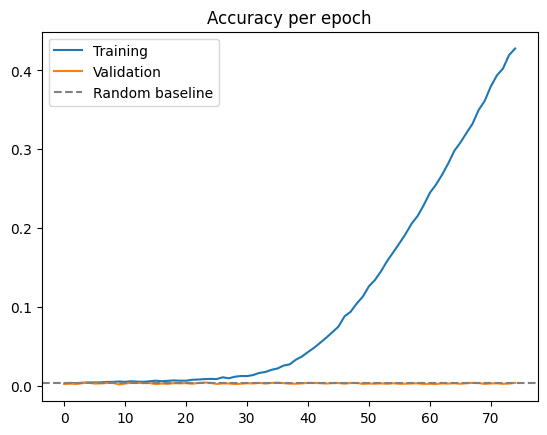

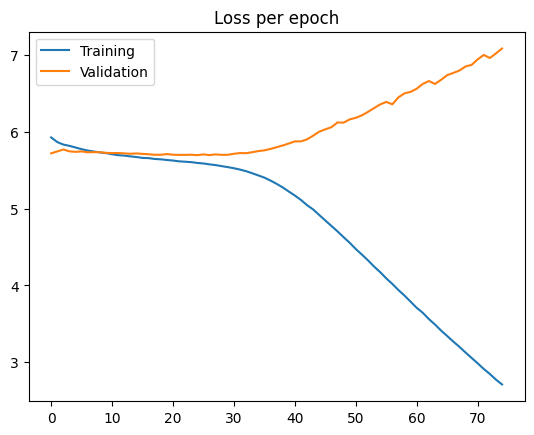

In [ ]:
import matplotlib.pyplot as plt


plt.plot(cnn_history.history['accuracy'], label='Training')
plt.plot(cnn_history.history['val_accuracy'], label='Validation')
plt.axhline(y=1/256, color='gray', linestyle='--', label='Random baseline')
plt.legend()
plt.title("Accuracy per epoch")
plt.show()

plt.plot(cnn_history.history['loss'], label='Training')
plt.plot(cnn_history.history['val_loss'], label='Validation')
plt.legend()
plt.title("Loss per epoch")
plt.show()

In [ ]:
cnn_model.save('/content/drive/MyDrive/cnn_model.h5')

In [ ]:
cnn_model.save('/content/drive/MyDrive/cnn_model.keras')

### Attack

In [ ]:
atck_traces.shape

(10000, 700)

In [ ]:
cnn_predictions = cnn_model.predict(atck_traces)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [ ]:
num_traces_list, ranks = calculate_ranks_full(cnn_predictions, atck_pts, atck_keys, target_byte=2, rank_step=1000)

Correct key rank: 46
Correct key: 224
current_num_traces: 1000
Correct key rank: 17
Correct key: 224
current_num_traces: 2000
Correct key rank: 25
Correct key: 224
current_num_traces: 3000
Correct key rank: 10
Correct key: 224
current_num_traces: 4000
Correct key rank: 16
Correct key: 224
current_num_traces: 5000
Correct key rank: 2
Correct key: 224
current_num_traces: 6000
Correct key rank: 2
Correct key: 224
current_num_traces: 7000
Correct key rank: 1
Correct key: 224
current_num_traces: 8000
Correct key rank: 1
Correct key: 224
current_num_traces: 9000
Correct key rank: 1
Correct key: 224
current_num_traces: 10000


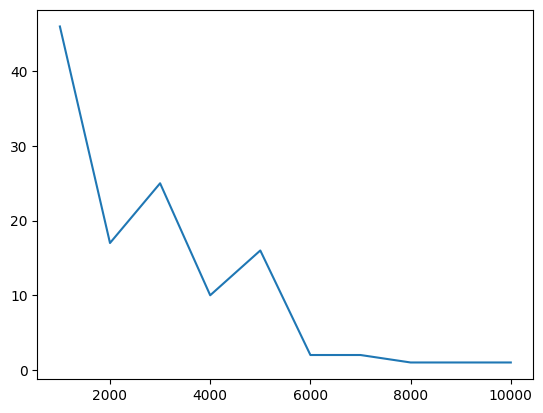

In [ ]:
plt.plot(num_traces_list, ranks)

## CNN ASCAD best

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, GlobalAveragePooling1D, Dense, Dropout, AveragePooling1D, Flatten
from tensorflow.keras.models import Model

def build_cnn_sca_model(classes=256,input_dim=700):
    # From VGG16 design
    input_shape = (input_dim,1)
    img_input = Input(shape=input_shape)
    # Block 1
    x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
    x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
    # Block 2
    x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
    x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
    # Block 3
    x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
    x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
    # Block 4
    x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
    x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
    # Block 5
    x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
    x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
    # Classification block
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)

    inputs = img_input
    # Create model.
    model = Model(inputs, x, name='cnn_best')
    optimizer = RMSprop(learning_rate=0.00001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

cnn_model_ascad = build_cnn_sca_model()
cnn_model_ascad.summary()

Model: "cnn_best"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 700, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv1D)           │ (None, 700, 64)        │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (AveragePooling1D)  │ (None, 350, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv1D)           │ (None, 350, 128)       │        90,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (AveragePooling1D)  │ (None, 175, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv1D)           │ (None, 175, 256)       │       360,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (AveragePooling1D)  │ (None, 87, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv1D)           │ (None, 87, 512)        │     1,442,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (AveragePooling1D)  │ (None, 43, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv1D)           │ (None, 43, 512)        │     2,884,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (AveragePooling1D)  │ (None, 21, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10752)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │    44,044,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 256)            │     1,048,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,652,544 (254.26 MB)

 Trainable params: 66,652,544 (254.26 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(profiling_traces_reshaped, profiling_labels_cat, test_size=0.2, random_state=42)

In [ ]:
cnn_ascad_history = cnn_model_ascad.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 58ms/step - accuracy: 0.0039 - loss: 5.5614 - val_accuracy: 0.0058 - val_loss: 5.5460
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0038 - loss: 5.5457 - val_accuracy: 0.0036 - val_loss: 5.5471
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0045 - loss: 5.5446 - val_accuracy: 0.0041 - val_loss: 5.5463
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0037 - loss: 5.5438 - val_accuracy: 0.0059 - val_loss: 5.5462
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0046 - loss: 5.5439 - val_accuracy: 0.0041 - val_loss: 5.5460
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0041 - loss: 5.5431 - val_accuracy: 0.0031 - val_loss: 5.5458
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0042 - loss: 5.5439 - val_accuracy: 0.0037 - val_loss: 5.5468
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0041 - loss: 5.5435 - val_acc

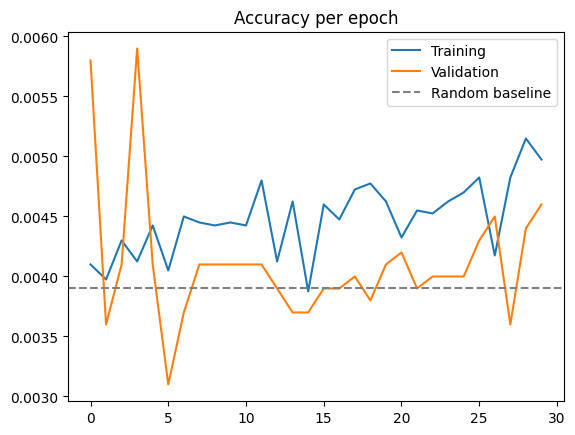

<ipython-input-24-ea20b8ef583e>:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


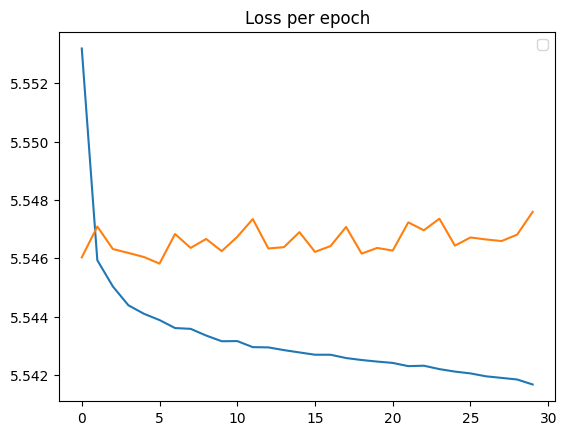

In [ ]:
import matplotlib.pyplot as plt


plt.plot(cnn_ascad_history.history['accuracy'], label='Training')
plt.plot(cnn_ascad_history.history['val_accuracy'], label='Validation')
plt.axhline(y=1/256, color='gray', linestyle='--', label='Random baseline')
plt.legend()
plt.title("Accuracy per epoch")
plt.show()

plt.plot(cnn_ascad_history.history['loss'])
plt.plot(cnn_ascad_history.history['val_loss'])
plt.legend()
plt.title("Loss per epoch")
plt.show()

### Attack

In [ ]:
cnn_predictions[:2000, :].shape

(2000, 256)

In [ ]:
cnn_predictions = cnn_model_ascad.predict(atck_traces)[:2000, :]
num_traces_list, ranks = calculate_ranks_full(cnn_predictions, atck_pts, atck_keys, target_byte=2, rank_step=1)
plt.plot(num_traces_list, ranks)

---
# ASCAD setup

In [18]:
import os
import os.path
import sys
import h5py
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, AveragePooling1D, BatchNormalization, Activation, Add, add
from tensorflow.keras import backend as K
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [ ]:
def cnn_best(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	x = Dense(classes, activation='softmax', name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(learning_rate=0.00001)
	model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	return model

In [15]:
def check_file_exists(file_path):
	file_path = os.path.normpath(file_path)
	if os.path.exists(file_path) == False:
		print("Error: provided file path '%s' does not exist!" % file_path)
		sys.exit(-1)
	return

In [14]:
def load_ascad(ascad_database_file, load_metadata=False):
	check_file_exists(ascad_database_file)
	# Open the ASCAD database HDF5 for reading
	try:
		in_file	 = h5py.File(ascad_database_file, "r")
	except:
		print("Error: can't open HDF5 file '%s' for reading (it might be malformed) ..." % ascad_database_file)
		sys.exit(-1)
	# Load profiling traces
	X_profiling = np.array(in_file['Profiling_traces/traces'], dtype=np.int8)
	# Load profiling labels
	Y_profiling = np.array(in_file['Profiling_traces/labels'])
	# Load attacking traces
	X_attack = np.array(in_file['Attack_traces/traces'], dtype=np.int8)
	# Load attacking labels
	Y_attack = np.array(in_file['Attack_traces/labels'])
	if load_metadata == False:
		return (X_profiling, Y_profiling), (X_attack, Y_attack)
	else:
		return (X_profiling, Y_profiling), (X_attack, Y_attack), (in_file['Profiling_traces/metadata'], in_file['Attack_traces/metadata'])

In [ ]:
# save_file_name,
def train_model(X_profiling, Y_profiling, model, epochs=150, batch_size=100, multilabel=0, validation_split=0, early_stopping=0):
	# check_file_exists(os.path.dirname(save_file_name))
	# Save model calllback
	# save_model = ModelCheckpoint(save_file_name)
	callbacks=[] #save_model
	# Early stopping callback
	if (early_stopping != 0):
		if validation_split == 0:
			validation_split=0.1
		callbacks.append(EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True))
	# Get the input layer shape
	# if isinstance(model.get_layer(index=0).shape, list):
	# 	input_layer_shape = model.get_layer(index=0).shape[0]
	# else:
	input_layer_shape = (200, 700, 1)#model.get_layer(index=0).shape
	# Sanity check
	if input_layer_shape[1] != len(X_profiling[0]):
		print("Error: model input shape %d instead of %d is not expected ..." % (input_layer_shape[1], len(X_profiling[0])))
		sys.exit(-1)
	# Adapt the data shape according our model input
	if len(input_layer_shape) == 2:
		# This is a MLP
		Reshaped_X_profiling = X_profiling
	elif len(input_layer_shape) == 3:
		# This is a CNN: expand the dimensions
		Reshaped_X_profiling = X_profiling.reshape((X_profiling.shape[0], X_profiling.shape[1], 1))
	else:
		print("Error: model input shape length %d is not expected ..." % len(input_layer_shape))
		sys.exit(-1)
	y=to_categorical(Y_profiling, num_classes=256)
	history = model.fit(x=Reshaped_X_profiling, y=y, batch_size=batch_size, verbose = 1, validation_split=validation_split, epochs=epochs, callbacks=callbacks)
	return history

In [11]:
ascad_database = "/content/drive/MyDrive/ASCAD_databases/ASCAD.h5"
network_type = "cnn"
validation_split = 0
multilabel = 0
train_len = 0
epochs = 75
batch_size = 200
bugfix = 0

In [12]:
def create_tf_dataset(X, y, batch_size=64, shuffle=True):
  ds = tf.data.Dataset.from_tensor_slices((X, y))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(X))
  ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
  return ds

In [19]:
from sklearn.model_selection import train_test_split

RANDOM_STATE=42
VAL_SIZE = 0.1

(X_profiling, Y_profiling), (X_attack, Y_attack) = load_ascad(ascad_database)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_profiling, Y_profiling, test_size=VAL_SIZE, random_state=RANDOM_STATE
)

Y_train_cat = to_categorical(Y_train, num_classes=256)
Y_val_cat = to_categorical(Y_val, num_classes=256)

In [20]:
ds_train = create_tf_dataset(X_train, Y_train_cat)
ds_val = create_tf_dataset(X_val, Y_val_cat, shuffle=False)

In [ ]:
import gc
del X_profiling
del Y_profiling
# del X_attack
# del Y_attack

gc.collect()

1285

In [ ]:
print(X_profiling.shape)
print(Y_profiling.shape)

(50000, 700)
(50000,)


In [ ]:
print(Y_train.shape)
print(Y_val.shape)

(45000,)
(5000,)


In [ ]:
print(X_train.shape)
print(X_val.shape)

(45000, 700)
(5000, 700)


In [ ]:
best_model = cnn_best(input_dim=len(X_train[0]))

In [ ]:
best_model.summary()

Model: "cnn_best"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 700, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv1D)           │ (None, 700, 64)        │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (AveragePooling1D)  │ (None, 350, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv1D)           │ (None, 350, 128)       │        90,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (AveragePooling1D)  │ (None, 175, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv1D)           │ (None, 175, 256)       │       360,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (AveragePooling1D)  │ (None, 87, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv1D)           │ (None, 87, 512)        │     1,442,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (AveragePooling1D)  │ (None, 43, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv1D)           │ (None, 43, 512)        │     2,884,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (AveragePooling1D)  │ (None, 21, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10752)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │    44,044,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 256)            │     1,048,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,652,544 (254.26 MB)

 Trainable params: 66,652,544 (254.26 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
tf.keras.config.disable_traceback_filtering()

In [ ]:
early_stopping = 0
history = train_model(X_train, Y_train, best_model, epochs, batch_size, multilabel, early_stopping=0)

Epoch 1/75
225/225 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.0039 - loss: 5.5618
Epoch 2/75
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.0047 - loss: 5.5456
Epoch 3/75
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.0042 - loss: 5.5453
Epoch 4/75
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.0043 - loss: 5.5442
Epoch 5/75
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.0050 - loss: 5.5437
Epoch 6/75
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.0047 - loss: 5.5428
Epoch 7/75
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.0048 - loss: 5.5432
Epoch 8/75
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.0048 - loss: 5.5429
Epoch 9/75
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.0049 - loss: 5.5434
Epoch 10/75
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.0042 - loss: 5.5432
Epoch 11/75
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.0049 - loss: 5.5431
Epoch 12/75
225/225 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
best_predictions = best_model.predict(X_attack)

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step


In [ ]:
steps, ranks = run_rank_trials(best_predictions, atck_metadata, n_traces_per_trial=1000, n_trials=10)


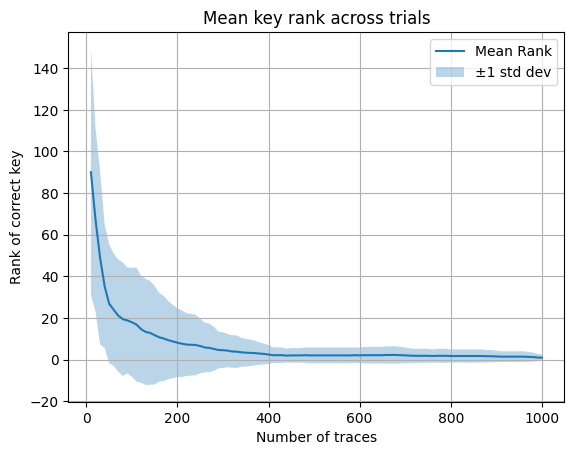

In [ ]:
plot_mean_rank(steps, ranks)

In [ ]:
def rank(predictions, metadata, real_key, min_trace_idx, max_trace_idx, last_key_bytes_proba, target_byte, simulated_key):
	# Compute the rank
	if len(last_key_bytes_proba) == 0:
		# If this is the first rank we compute, initialize all the estimates to zero
		key_bytes_proba = np.zeros(256)
	else:
		# This is not the first rank we compute: we optimize things by using the
		# previous computations to save time!
		key_bytes_proba = last_key_bytes_proba

	for p in range(0, max_trace_idx-min_trace_idx):
		# Go back from the class to the key byte. '2' is the index of the byte (third byte) of interest.
		plaintext = metadata[min_trace_idx + p]['plaintext'][target_byte]
		key = metadata[min_trace_idx + p]['key'][target_byte]
		for i in range(0, 256):
			# Our candidate key byte probability is the sum of the predictions logs
			if (simulated_key!=1):
				proba = predictions[p][SBOX[plaintext ^ i]]
			else:
				proba = predictions[p][SBOX[plaintext ^ key ^ i]]
			if proba != 0:
				key_bytes_proba[i] += np.log(proba)
			else:
				# We do not want an -inf here, put a very small epsilon
				# that correspondis to a power of our min non zero proba
				min_proba_predictions = predictions[p][np.array(predictions[p]) != 0]
				if len(min_proba_predictions) == 0:
					print("Error: got a prediction with only zeroes ... this should not happen!")
					sys.exit(-1)
				min_proba = min(min_proba_predictions)
				key_bytes_proba[i] += np.log(min_proba**2)
	# Now we find where our real key candidate lies in the estimation.
	# We do this by sorting our estimates and find the rank in the sorted array.
	sorted_proba = np.array(list(map(lambda a : key_bytes_proba[a], key_bytes_proba.argsort()[::-1])))
	real_key_rank = np.where(sorted_proba == key_bytes_proba[real_key])[0][0]
	return (real_key_rank, key_bytes_proba)

def full_ranks(predictions, dataset, metadata, min_trace_idx, max_trace_idx, rank_step, target_byte, simulated_key):
	print("Computing rank for targeted byte {}".format(target_byte))
	# Real key byte value that we will use. '2' is the index of the byte (third byte) of interest.
	if (simulated_key!=1):
		real_key = metadata[0]['key'][target_byte]
	else:
		real_key = 0
	# Check for overflow
	if max_trace_idx > dataset.shape[0]:
		print("Error: asked trace index %d overflows the total traces number %d" % (max_trace_idx, dataset.shape[0]))
		sys.exit(-1)
	index = np.arange(min_trace_idx+rank_step, max_trace_idx, rank_step)
	f_ranks = np.zeros((len(index), 2), dtype=np.uint32)
	key_bytes_proba = []
	for t, i in zip(index, range(0, len(index))):
		real_key_rank, key_bytes_proba = rank(predictions[t-rank_step:t], metadata, real_key, t-rank_step, t, key_bytes_proba, target_byte, simulated_key)
		f_ranks[i] = [t - min_trace_idx, real_key_rank]
	return f_ranks

In [ ]:
def rank(predictions, metadata, real_key, traces_idxs, last_key_bytes_proba, target_byte, simulated_key):
	# Compute the rank
	if len(last_key_bytes_proba) == 0:
		# If this is the first rank we compute, initialize all the estimates to zero
		key_bytes_proba = np.zeros(256)
	else:
		# This is not the first rank we compute: we optimize things by using the
		# previous computations to save time!
		key_bytes_proba = last_key_bytes_proba

	for t_idx in traces_idxs:
		# Go back from the class to the key byte. '2' is the index of the byte (third byte) of interest.
		plaintext = metadata[t_idx]['plaintext'][target_byte]
		key = metadata[t_idx]['key'][target_byte]
		for key_guess in range(0, 256):
			# Our candidate key byte probability is the sum of the predictions logs
			if (simulated_key!=1):
				proba = predictions[t_idx][SBOX[plaintext ^ key_guess]]
			else:
				proba = predictions[t_idx][SBOX[plaintext ^ key ^ key_guess]]
			if proba != 0:
				key_bytes_proba[key_guess] += np.log(proba)
			else:
				# We do not want an -inf here, put a very small epsilon
				# that correspondis to a power of our min non zero proba
				min_proba_predictions = predictions[t_idx][np.array(predictions[t_idx]) != 0]
				if len(min_proba_predictions) == 0:
					print("Error: got a prediction with only zeroes ... this should not happen!")
					sys.exit(-1)
				min_proba = min(min_proba_predictions)
				key_bytes_proba[key_guess] += np.log(min_proba**2)
	# Now we find where our real key candidate lies in the estimation.
	# We do this by sorting our estimates and find the rank in the sorted array.
	sorted_proba = np.array(list(map(lambda a : key_bytes_proba[a], key_bytes_proba.argsort()[::-1])))
	real_key_rank = np.where(sorted_proba == key_bytes_proba[real_key])[0][0]
	return (real_key_rank, key_bytes_proba)

def full_ranks(predictions, dataset, metadata, trace_idxs, rank_step, target_byte, simulated_key):
	print("Computing rank for targeted byte {}".format(target_byte))
	# Real key byte value that we will use. '2' is the index of the byte (third byte) of interest.
	if (simulated_key!=1):
		real_key = metadata[0]['key'][target_byte]
	else:
		real_key = 0
	# Check for overflow
	if max_trace_idx > dataset.shape[0]:
		print("Error: asked trace index %d overflows the total traces number %d" % (max_trace_idx, dataset.shape[0]))
		sys.exit(-1)
	# index = np.arange(min_trace_idx+rank_step, max_trace_idx, rank_step)
	f_ranks = np.zeros((len(trace_idxs), 2), dtype=np.uint32)
	key_bytes_proba = []
	for i, t in enumerate(trace_idxs):
		real_key_rank, key_bytes_proba = rank(predictions[trace_idxs], metadata, real_key, trace_idxs, key_bytes_proba, target_byte, simulated_key)
		f_ranks[i] = [t - min_trace_idx, real_key_rank]
	return f_ranks

In [ ]:
from tqdm import tqdm

def run_rank_trials(predictions, metadata, n_traces_per_trial=1000, n_trials=10, rank_step=10, target_byte=2, simulated_key=0):
    real_key = metadata[0]['key'][target_byte] if not simulated_key else 0

    max_trace_idx = predictions.shape[0]
    steps = list(range(rank_step, n_traces_per_trial + 1, rank_step))

    all_ranks = []

    for trial in tqdm(range(n_trials), desc="Trials"):
        trace_indices = np.random.choice(np.arange(max_trace_idx), size=n_traces_per_trial, replace=False)
        trial_ranks = []
        key_bytes_proba = []

        for i in tqdm(steps, leave=False, desc=f"Rank steps (Trial {trial+1})"):
            selected = trace_indices[:i]
            rank_val, key_bytes_proba = rank(predictions, metadata, real_key, selected, key_bytes_proba, target_byte, simulated_key)
            trial_ranks.append(rank_val)

        all_ranks.append(trial_ranks)

    return steps, np.array(all_ranks)

In [ ]:
def plot_mean_rank(steps, ranks_matrix):
    import matplotlib.pyplot as plt
    mean_ranks = np.mean(ranks_matrix, axis=0)
    std_ranks = np.std(ranks_matrix, axis=0)

    plt.plot(steps, mean_ranks, label='Mean Rank')
    plt.fill_between(steps, mean_ranks - std_ranks, mean_ranks + std_ranks, alpha=0.3, label='±1 std dev')
    plt.xlabel("Number of traces")
    plt.ylabel("Rank of correct key")
    plt.title("Mean key rank across trials")
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
def check_model(model, ascad_database, num_traces=2000, target_byte=2, multilabel=0, simulated_key=0, save_file=""):
	# check_file_exists(model_file)
	check_file_exists(ascad_database)
	# Load profiling and attack data and metadata from the ASCAD database
	(X_profiling, Y_profiling), (X_attack, Y_attack), (Metadata_profiling, Metadata_attack) = load_ascad(ascad_database, load_metadata=True)
	# Load model
	# model = best_model
	# Get the input layer shape
	input_layer_shape = (2000, 700, 1) #model.get_layer(index=0).input_shape[0]
	# if isinstance(model.get_layer(index=0).input_shape, list):
	# 	input_layer_shape = model.get_layer(index=0).input_shape[0]
	# else:
	# 	input_layer_shape = model.get_layer(index=0).input_shape
	# Sanity check
	if input_layer_shape[1] != len(X_attack[0, :]):
		print("Error: model input shape %d instead of %d is not expected ..." % (input_layer_shape[1], len(X_attack[0, :])))
		sys.exit(-1)
	# Adapt the data shape according our model input
	if len(input_layer_shape) == 2:
		# This is a MLP
		input_data = X_attack[:num_traces, :]
	elif len(input_layer_shape) == 3:
		# This is a CNN: reshape the data
		input_data = X_attack[:num_traces, :]
		input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))
	else:
		print("Error: model input shape length %d is not expected ..." % len(input_layer_shape))
		sys.exit(-1)
	# Predict our probabilities
	# print(f"input_data - {input_data}")
	# print(f"input_data - {input_data.shape}")
	predictions = model.predict(atck_traces)
	# if (multilabel!=0):
	# 	if (multilabel==1):
	# 		predictions_sbox = multilabel_predict(predictions)
	# 	else:
	# 		predictions_sbox = multilabel_without_permind_predict(predictions)
	# 	for target_byte in range(16):
	# 		ranks_i = full_ranks(predictions_sbox[target_byte], X_attack, Metadata_attack, 0, num_traces, 10, target_byte,	simulated_key)
	# 		# We plot the results
	# 		x_i = [ranks_i[i][0] for i in range(0, ranks_i.shape[0])]
	# 		y_i = [ranks_i[i][1] for i in range(0, ranks_i.shape[0])]
	# 		plt.plot(x_i, y_i, label="key_"+str(target_byte))
	# 	# plt.title('Performance of '+model_file+' against '+ascad_database)
	# 	plt.xlabel('number of traces')
	# 	plt.ylabel('rank')
	# 	plt.grid(True)
	# 	plt.legend(loc='upper right')
	# 	if (save_file != ""):
	# 		plt.savefig(save_file)
	# 	else:
	# 		plt.show(block=False)

	# else:
	predictions_sbox_i = predictions
	# We test the rank over traces of the Attack dataset, with a step of 10 traces
	ranks = full_ranks(predictions_sbox_i, X_attack, Metadata_attack, 0, num_traces, 10, target_byte, simulated_key)
	# We plot the results
	x = [ranks[i][0] for i in range(0, ranks.shape[0])]
	y = [ranks[i][1] for i in range(0, ranks.shape[0])]
	# plt.title('Performance of '+model_file+' against '+ascad_database)
	plt.xlabel('number of traces')
	plt.ylabel('rank')
	plt.grid(True)
	plt.plot(x, y)
	plt.show(block=False)
	if (save_file != ""):
		plt.savefig(save_file)
	else:
		plt.show(block=False)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Computing rank for targeted byte 2


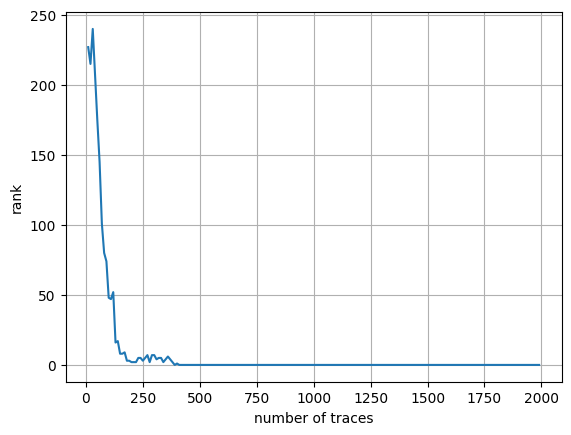

In [ ]:
import matplotlib.pyplot as plt

check_model(best_model, ascad_database)

In [ ]:
check_model(best_model, ascad_database, num_traces=200)

NameError: name 'best_model' is not defined

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Computing rank for targeted byte 2


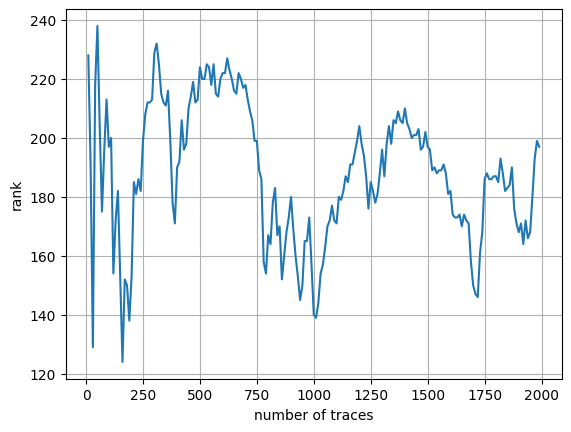

In [ ]:
check_model(cnn_model_ascad, ascad_database)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Computing rank for targeted byte 2


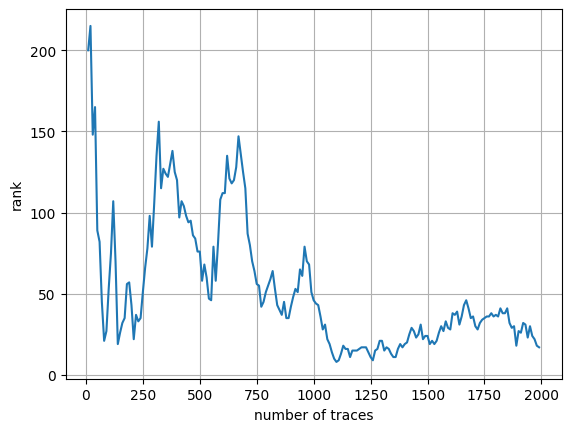

In [ ]:
check_model(cnn_model, ascad_database)

# SE layer

In [8]:
from tensorflow.keras.layers import GlobalAveragePooling1D, Dense, Reshape, Multiply, Dropout

def se_block(input_tensor, ratio=16):
  channels = input_tensor.shape[-1]
  se = GlobalAveragePooling1D()(input_tensor)
  se = Dense(channels // ratio, activation='relu')(se)
  se = Dense(channels, activation='sigmoid')(se)
  se = Reshape((1, channels))(se)
  return Multiply()([input_tensor, se])

In [7]:
def cnn_squeeze_excite(filters, se_ratio, dropout_rate, classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(filters[0], 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	# Block 2
	x = Conv1D(filters[1], 11, activation='relu', padding='same', name='block2_conv1')(x)
	# Squeeze excitation block 1
	x = se_block(x, ratio=se_ratio)
	x = MaxPooling1D(2)(x)

	# Block 3
	x = Conv1D(filters[2], 11, activation='relu', padding='same', name='block3_conv1')(x)
	# Block 4
	x = Conv1D(filters[3], 11, activation='relu', padding='same', name='block4_conv1')(x)
  # Block 5
	x = Conv1D(filters[4], 11, activation='relu', padding='same', name='block5_conv1')(x)
 	# Squeeze excitation block 1
	x = se_block(x, ratio=se_ratio)
	x = MaxPooling1D(2)(x)

	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dropout(dropout_rate)(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	x = Dropout(dropout_rate)(x)
	x = Dense(classes, activation='softmax', name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_squeeze_excitation')
	optimizer = RMSprop(learning_rate=0.00001)
	model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	return model

In [6]:
def vgg_se_builder(hp):
  base_filters = hp.Choice("filter_scale", [1.0, 1.5, 2.0])
  filters = [int(f * base_filters) for f in [64, 128, 256, 512, 512]]
  dropout = hp.Float('dropout', 0.0, 0.6, step=0.3)
  se_ratio = hp.Choice('se_ratio', [8, 16, 32])

  model = cnn_squeeze_excite(filters=filters, dropout_rate=dropout, se_ratio=se_ratio)

  learning_rate = hp.Choice("learning_rate", [1e-5, 5e-5, 1e-4, 5e-4])
  optimizer = RMSprop(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

  return model

In [3]:
!pip install keras-tuner --upgrade
import keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.3 MB/s eta 0:00:00


In [ ]:
def data_generator(traces, labels, batch_size, num_classes, shuffle=False):
    num_samples = len(labels)
    indices = np.arange(num_samples)

    while True:
        if shuffle:
            np.random.shuffle(indices)
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]
            batch_traces = np.expand_dims(traces[batch_indices].astype(np.float32), axis=-1)
            batch_labels = tf.keras.utils.to_categorical(labels[batch_indices], num_classes=num_classes).astype(np.float32)
            yield batch_traces, batch_labels
        if not shuffle: # Only iterate once for validation/attack
            break

def create_tf_dataset(traces, labels, batch_size, num_classes, shuffle=False):
    return tf.data.Dataset.from_generator(
        lambda: data_generator(traces, labels, batch_size, num_classes, shuffle),
        output_signature=(
            tf.TensorSpec(shape=(None, 700, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32)
        )
    )

def load_ascad_with_split(ascad_database_file, batch_size, validation_size=0.2, num_classes=256):
    check_file_exists(ascad_database_file)
    try:
        in_file = h5py.File(ascad_database_file, "r")
        profiling_traces = np.array(in_file['Profiling_traces/traces'], dtype=np.int8)
        profiling_labels = np.array(in_file['Profiling_traces/labels'])
        attack_traces = np.array(in_file['Attack_traces/traces'], dtype=np.int8)
        attack_labels = np.array(in_file['Attack_traces/labels'])
        in_file.close()
    except Exception as e:
        print(f"Error loading ASCAD data: {e}")
        sys.exit(-1)

    # Split profiling data
    train_traces, val_traces, train_labels, val_labels = train_test_split(
        profiling_traces, profiling_labels, test_size=validation_size, stratify=profiling_labels, random_state=42 # for reproducibility
    )

    train_dataset = create_tf_dataset(train_traces, train_labels, batch_size, num_classes, shuffle=True)
    val_dataset = create_tf_dataset(val_traces, val_labels, batch_size, num_classes, shuffle=False).cache()
    attack_dataset = create_tf_dataset(attack_traces, attack_labels, batch_size, num_classes, shuffle=False).cache()

    return train_dataset, val_dataset, attack_dataset

In [4]:
import keras_tuner as kt
import tensorflow.keras.backend as K
from tensorflow.keras.models import clone_model

class CleanMemoryTuner(kt.RandomSearch):
  def run_trial(self, trial, *args, **kwargs):
    K.clear_session()
    return super().run_trial(trial, *args, **kwargs)

In [9]:
tuner = CleanMemoryTuner(
    hypermodel=vgg_se_builder,
    objective="val_loss",
    max_trials=15,
    executions_per_trial=1,
    directory="/content/drive/MyDrive/tuner_dir",
    project_name="vgg_se_ascad"
)

Reloading Tuner from /content/drive/MyDrive/tuner_dir/vgg_se_ascad/tuner0.json


In [ ]:
Y_train_cat = to_categorical(Y_train, num_classes=256)
Y_val_cat = to_categorical(Y_val, num_classes=256)

In [ ]:
train_data, val_data, attack_data = load_ascad_with_split(ascad_database, batch_size=128, validation_size=0.2, num_classes=256)

In [ ]:
!nvidia-smi

Mon May 12 23:47:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   73C    P0             34W /   72W |   21187MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("/content/drive/MyDrive/vgg_se_trial.keras", save_best_only=True)
tuner.search(ds_train, validation_data=ds_val, callbacks=[early_stop, checkpoint], epochs=75, batch_size=64)

Trial 15 Complete [00h 29m 38s]
val_loss: 5.544346332550049

Best val_loss So Far: 5.544346332550049
Total elapsed time: 1d 00h 00m 13s


In [22]:
best_model_vgg_se = tuner.get_best_models(1)[0]
print(best_model_vgg_se.summary())
best_model_vgg_se.save("/content/drive/MyDrive/vgg_se_best.keras")
# best_model_vgg_se.save_weights("/content/drive/MyDrive/vgg_se_best_weights.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "cnn_squeeze_excitation"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 700, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 700, 128)  │      1,536 │ input_layer[0][0] │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 700, 256)  │    360,704 │ block1_conv1[0][… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ block2_conv1[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │      4,112 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │      4,352 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 256)    │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 700, 256)  │          0 │ block2_conv1[0][… │
│                     │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 350, 256)  │          0 │ multiply[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 350, 512)  │  1,442,304 │ max_pooling1d[0]… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 350, 1024) │  5,768,192 │ block3_conv1[0][… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 350, 1024) │ 11,535,360 │ block4_conv1[0][… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1024)      │          0 │ block5_conv1[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     65,600 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1024)      │     66,560 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1024)   │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 350, 1024) │          0 │ block5_conv1[0][… │
│ (Multiply)          │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 175, 1024) │          0 │ multiply_1[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 179200)    │          0 │ max_pooling1d_1[

 Total params: 771,086,160 (2.87 GB)

 Trainable params: 771,086,160 (2.87 GB)

 Non-trainable params: 0 (0.00 B)

None


In [24]:
import json
# [Optional] Save best hyperparameters in a json file

best_hps = tuner.get_best_hyperparameters(1)[0]
with open("/content/drive/MyDrive/vgg_se_best_hps.json", "w") as f:
    json.dump(best_hps.values, f)

In [25]:
top_trials = tuner.oracle.get_best_trials(num_trials=5)

for i, trial in enumerate(top_trials):
    print(f"Trial {i+1}: {trial.score}")
    print(f"-> Parameters {trial.hyperparameters.values}")

with open("/content/drive/MyDrive/vgg_se_top_trials.json", "w") as f:
    json.dump([trial.hyperparameters.values for trial in top_trials], f)

Trial 1: 5.544346332550049
-> Parameters {'filter_scale': 2.0, 'dropout': 0.1, 'se_ratio': 16, 'learning_rate': 5e-05}
Trial 2: 5.544490337371826
-> Parameters {'filter_scale': 2.0, 'dropout': 0.1, 'se_ratio': 32, 'learning_rate': 0.0001}
Trial 3: 5.544567584991455
-> Parameters {'filter_scale': 2.0, 'dropout': 0.1, 'se_ratio': 32, 'learning_rate': 0.0005}
Trial 4: 5.54458475112915
-> Parameters {'filter_scale': 1.0, 'dropout': 0.2, 'se_ratio': 32, 'learning_rate': 0.0005}
Trial 5: 5.544618129730225
-> Parameters {'filter_scale': 1.5, 'dropout': 0.5, 'se_ratio': 16, 'learning_rate': 0.0001}


In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
se_cnn = cnn_squeeze_excite()

In [ ]:
se_cnn.summary()

In [ ]:
history_se_cnn  = train_model(X_profiling, Y_profiling, se_cnn, epochs=75, batch_size=200)

Epoch 1/75
250/250 ━━━━━━━━━━━━━━━━━━━━ 159s 541ms/step - accuracy: 0.0034 - loss: 5.5523
Epoch 2/75
250/250 ━━━━━━━━━━━━━━━━━━━━ 135s 538ms/step - accuracy: 0.0050 - loss: 5.5445
Epoch 3/75
250/250 ━━━━━━━━━━━━━━━━━━━━ 134s 537ms/step - accuracy: 0.0046 - loss: 5.5439
Epoch 4/75
250/250 ━━━━━━━━━━━━━━━━━━━━ 134s 537ms/step - accuracy: 0.0048 - loss: 5.5440
Epoch 5/75
250/250 ━━━━━━━━━━━━━━━━━━━━ 134s 537ms/step - accuracy: 0.0047 - loss: 5.5435
Epoch 6/75
250/250 ━━━━━━━━━━━━━━━━━━━━ 134s 536ms/step - accuracy: 0.0055 - loss: 5.5424
Epoch 7/75
250/250 ━━━━━━━━━━━━━━━━━━━━ 134s 536ms/step - accuracy: 0.0047 - loss: 5.5429
Epoch 8/75
250/250 ━━━━━━━━━━━━━━━━━━━━ 134s 536ms/step - accuracy: 0.0048 - loss: 5.5429
Epoch 9/75
250/250 ━━━━━━━━━━━━━━━━━━━━ 134s 537ms/step - accuracy: 0.0052 - loss: 5.5425
Epoch 10/75
250/250 ━━━━━━━━━━━━━━━━━━━━ 134s 537ms/step - accuracy: 0.0048 - loss: 5.5427
Epoch 11/75
250/250 ━━━━━━━━━━━━━━━━━━━━ 134s 537ms/step - accuracy: 0.0051 - loss: 5.5421
Epoch 12

KeyError: 'val_accuracy'

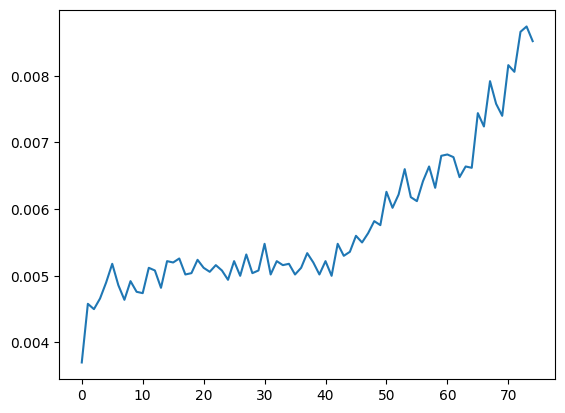

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history_se_cnn.history['accuracy'], label='Training')
plt.plot(history_se_cnn.history['val_accuracy'], label='Validation')
plt.axhline(y=1/256, color='gray', linestyle='--', label='Random baseline')
plt.legend()
plt.title("Accuracy per epoch")
plt.show()

plt.plot(history_se_cnn.history['loss'])
plt.plot(history_se_cnn.history['val_loss'])
plt.legend()
plt.title("Loss per epoch")
plt.show()

### Attack


313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step
Computing rank for targeted byte 2


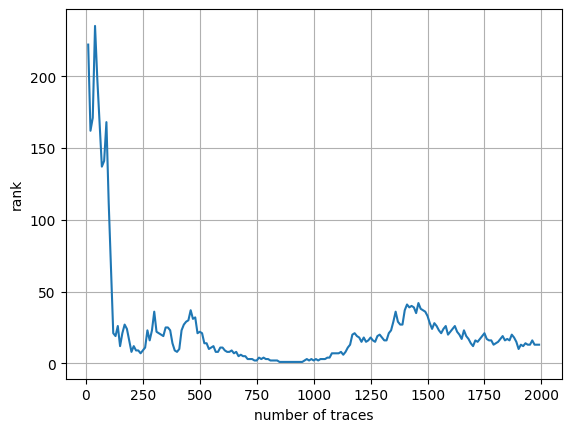

In [ ]:
check_model(se_cnn, ascad_database)

# SE applied to VGG

In [ ]:
def vgg_cnn_se(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = BatchNormalization()(x)
	x = AveragePooling1D(2, strides=2, name='block1_pool1')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = BatchNormalization()(x)
	# Squeeze excitation block 1
	x = se_block(x)
	x = AveragePooling1D(2, strides=2, name='block1_pool2')(x)

	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = BatchNormalization()(x)
	x = AveragePooling1D(2, strides=2, name='block1_pool3')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = BatchNormalization()(x)
	x = AveragePooling1D(2, strides=2, name='block1_pool4')(x)
  # Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = BatchNormalization()(x)
 	# Squeeze excitation block 1
	x = se_block(x)
	x = AveragePooling1D(2, strides=2, name='block1_pool5')(x)

	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	x = Dense(classes, activation='softmax', name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_squeeze_excitation')
	optimizer = RMSprop(learning_rate=0.00001)
	model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	return model

In [ ]:
vgg_se = vgg_cnn_se()
vgg_se.summary()

Model: "cnn_squeeze_excitation"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 700, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 700, 64)   │        768 │ input_layer_1[0]… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 700, 64)   │        256 │ block1_conv1[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool1        │ (None, 350, 64)   │          0 │ batch_normalizat… │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 350, 128)  │     90,240 │ block1_pool1[0][… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 350, 128)  │        512 │ block2_conv1[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │      1,032 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      1,152 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 128)    │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 350, 128)  │          0 │ batch_normalizat… │
│                     │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool2        │ (None, 175, 128)  │          0 │ multiply[0][0]    │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 175, 256)  │    360,704 │ block1_pool2[0][… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 175, 256)  │      1,024 │ block3_conv1[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool3        │ (None, 87, 256)   │          0 │ batch_normalizat… │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 87, 512)   │  1,442,304 │ block1_pool3[0][… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 87, 512)   │      2,048 │ block4_conv1[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool4        │ (None, 43, 512)   │          0 │ batch_normalizat

 Total params: 66,693,928 (254.42 MB)

 Trainable params: 66,690,984 (254.41 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [ ]:
history_vgg_se  = train_model(X_profiling, Y_profiling, vgg_se, epochs=75, batch_size=200)

Epoch 1/75
250/250 ━━━━━━━━━━━━━━━━━━━━ 45s 107ms/step - accuracy: 0.0032 - loss: 5.5654
Epoch 2/75
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 111ms/step - accuracy: 0.0045 - loss: 5.5474
Epoch 3/75
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 114ms/step - accuracy: 0.0052 - loss: 5.5446
Epoch 4/75
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - accuracy: 0.0046 - loss: 5.5408
Epoch 5/75
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 111ms/step - accuracy: 0.0059 - loss: 5.5364
Epoch 6/75
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - accuracy: 0.0053 - loss: 5.5318
Epoch 7/75
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - accuracy: 0.0065 - loss: 5.5262
Epoch 8/75
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - accuracy: 0.0070 - loss: 5.5173
Epoch 9/75
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - accuracy: 0.0083 - loss: 5.5097
Epoch 10/75
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - accuracy: 0.0082 - loss: 5.4982
Epoch 11/75
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - accuracy: 0.0102 - loss: 5.4846
Epoch 12/75
250/250

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Computing rank for targeted byte 2


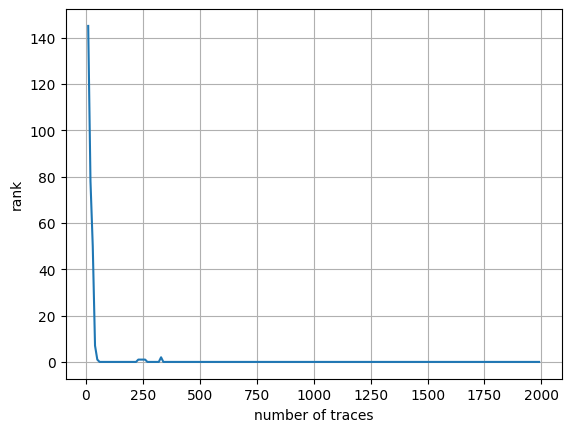

In [ ]:
import matplotlib.pyplot as plt
check_model(vgg_se, ascad_database)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Computing rank for targeted byte 2


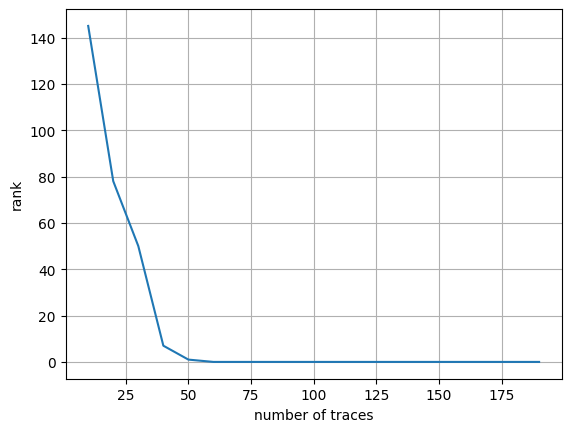

In [ ]:
check_model(vgg_se, ascad_database, num_traces=200)

# CBAM block

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, Lambda
from tensorflow.keras.layers import Dense, Reshape, Multiply, Add, Conv1D, Activation, Concatenate

def cbam_block(input_tensor, ratio=16, name_prefix="cbam"):
  channel = input_tensor.shape[-1]

  avg_pool = GlobalAveragePooling1D()(input_tensor)
  max_pool = GlobalMaxPooling1D()(input_tensor)

  shared_dense_1 = Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True)
  shared_dense_2 = Dense(channel, kernel_initializer='he_normal', use_bias=True)

  mlp_avg = shared_dense_2(shared_dense_1(avg_pool))
  mlp_max = shared_dense_2(shared_dense_1(max_pool))

  channel_attention = Activation('sigmoid')(Add()([mlp_avg, mlp_max]))
  channel_attention = Reshape((1, channel))(channel_attention)

  x = Multiply()([input_tensor, channel_attention])

  # avg_pool = tf.reduce_mean(x, axis=-1, keepdims=True)
  # max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
  avg_pool = Lambda(lambda z: K.mean(z, axis=-1, keepdims=True))(x)
  max_pool = Lambda(lambda z: K.max(z, axis=-1, keepdims=True))(x)
  concat = Concatenate(axis=-1)([avg_pool, max_pool])

  spatial_attention = Conv1D(filters=1, kernel_size=7, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)

  cbam_out = Multiply()([x, spatial_attention])
  return cbam_out

In [ ]:
def vgg_cnn_cbam(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = BatchNormalization()(x)
	x = AveragePooling1D(2, strides=2, name='block1_pool1')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = BatchNormalization()(x)
	# Squeeze excitation block 1
	x = cbam_block(x)
	x = AveragePooling1D(2, strides=2, name='block1_pool2')(x)

	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = BatchNormalization()(x)
	x = AveragePooling1D(2, strides=2, name='block1_pool3')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = BatchNormalization()(x)
	x = AveragePooling1D(2, strides=2, name='block1_pool4')(x)
  # Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = BatchNormalization()(x)
 	# Squeeze excitation block 1
	x = cbam_block(x)
	x = AveragePooling1D(2, strides=2, name='block1_pool5')(x)

	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	x = Dense(classes, activation='softmax', name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_squeeze_excitation')
	optimizer = RMSprop(learning_rate=0.00001)
	model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	return model

In [ ]:
vgg_cbam = vgg_cnn_cbam()
vgg_cbam.summary()

Model: "cnn_squeeze_excitation"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 700, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 700, 64)   │        768 │ input_layer_4[0]… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 700, 64)   │        256 │ block1_conv1[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool1        │ (None, 350, 64)   │          0 │ batch_normalizat… │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 350, 128)  │     90,240 │ block1_pool1[0][… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 350, 128)  │        512 │ block2_conv1[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 8)         │      1,032 │ global_average_p… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │      1,152 │ dense_8[0][0],    │
│                     │                   │            │ dense_8[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 128)       │          0 │ dense_9[0][0],    │
│                     │                   │            │ dense_9[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128)       │          0 │ add_2[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1, 128)    │          0 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 350, 128)  │          0 │ batch_normalizat… │
│ (Multiply)          │                   │            │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 350, 1)    │          0 │ multiply_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 350, 1)    │          0 │ multiply_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 350, 2)    │          0 │ lambda[0][0],     │
│ (Concatenate)       │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 350, 1)    │         14 │ concatenate[0][0

 Total params: 66,693,956 (254.42 MB)

 Trainable params: 66,691,012 (254.41 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [ ]:
history_vgg_cbam  = train_model(X_profiling, Y_profiling, vgg_cbam, epochs=75, batch_size=200)

Epoch 1/75
250/250 ━━━━━━━━━━━━━━━━━━━━ 38s 117ms/step - accuracy: 0.0036 - loss: 5.5468
Epoch 2/75
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 116ms/step - accuracy: 0.0049 - loss: 5.5434
Epoch 3/75
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 114ms/step - accuracy: 0.0047 - loss: 5.5413
Epoch 4/75
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 115ms/step - accuracy: 0.0053 - loss: 5.5395
Epoch 5/75
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 116ms/step - accuracy: 0.0051 - loss: 5.5373
Epoch 6/75
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 115ms/step - accuracy: 0.0061 - loss: 5.5337
Epoch 7/75
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 115ms/step - accuracy: 0.0069 - loss: 5.5293
Epoch 8/75
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 115ms/step - accuracy: 0.0076 - loss: 5.5221
Epoch 9/75
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 115ms/step - accuracy: 0.0083 - loss: 5.5150
Epoch 10/75
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 115ms/step - accuracy: 0.0085 - loss: 5.5030
Epoch 11/75
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 115ms/step - accuracy: 0.0104 - loss: 5.4917
Epoch 12/75
250/250

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
Computing rank for targeted byte 2


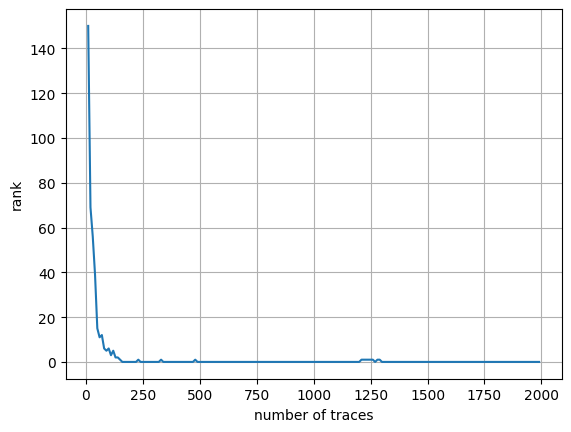

In [ ]:
import matplotlib.pyplot as plt
check_model(vgg_cbam, ascad_database)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Computing rank for targeted byte 2


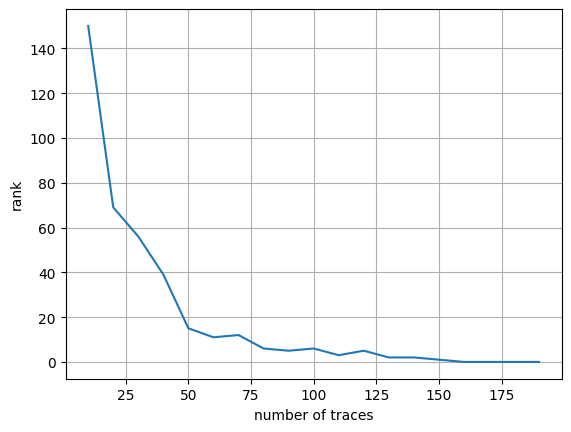

In [ ]:
check_model(vgg_cbam, ascad_database, num_traces=200)